---
title: Statistical analysis
description: Exploratory Data Analysis of Head Coaches and Match Results datasets
---

### Imports

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

In [2]:
sns.set_theme(context="paper", style="ticks", palette="deep", color_codes=True)
plt.rcParams["figure.autolayout"] = True
plt.rcParams["figure.dpi"] = 300

### Loading data

In [3]:
head_coach = pd.read_csv("data/head_coach.csv", parse_dates=["Appointed", "EndDate"])
head_coach = head_coach[head_coach["Tenure"] <= 3000]

### General plotting function

In [4]:
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm


def prepare_data(data, x_value, y_value, degree=2):
    x = data[x_value].values.reshape(-1, 1)
    y = data[y_value]
    polynomial_features = PolynomialFeatures(degree=degree)
    xp = polynomial_features.fit_transform(x)
    return xp, y, polynomial_features


def fit_model(xp, y):
    model = sm.OLS(y, xp)
    results = model.fit()
    return results


def create_predictions(results, polynomial_features, x_min, x_max):
    xs = np.linspace(x_min, x_max).reshape(-1, 1)
    xs = polynomial_features.transform(xs)
    ys = results.predict(xs)
    predictions = results.get_prediction(xs)
    ci = predictions.conf_int()
    return xs, ys, ci


def create_polynomial_regression_plot(
    data, x_value, y_value, y_leg, color, title, xlabel, degree=2, integer_ticks=False
):
    xp, y, polynomial_features = prepare_data(data, x_value, y_value, degree)
    results = fit_model(xp, y)
    xs, ys, ci = create_predictions(
        results, polynomial_features, data[x_value].min(), data[x_value].max()
    )

    plt.figure()
    plt.scatter(data[x_value], y, color=color, alpha=0.2)
    (line,) = plt.plot(xs[:, 1], ys, color=color)
    plt.fill_between(xs[:, 1], ci[:, 0], ci[:, 1], color=color, alpha=0.3)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(f"{y_leg.capitalize()} percentage")
    plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(xmax=100))

    if integer_ticks:
        plt.xticks(np.arange(min(data[x_value]), max(data[x_value]) + 1, 1.0))

    r, p = pearsonr(data[x_value], data[y_value])
    plt.legend(
        [line, line],
        [
            f"Polynomial regression (degree {degree})",
            f"Pearson correlation : $r = {r:.2f}$, $p = {p:.2f}$",
        ],
        loc="upper right",
    )

#### Relation between Head Coaches appointments results and Head Coaches Tenure in Club

In [5]:
head_coach["WinPercentage"] = head_coach["Wins"] / head_coach["Matches"] * 100
head_coach["DrawPercentage"] = head_coach["Draws"] / head_coach["Matches"] * 100
head_coach["LossPercentage"] = head_coach["Losses"] / head_coach["Matches"] * 100

title = "{} Ratio of Head Coach Appointment versus Head Coach Appointment Tenure"
x_label = "Head Coach Appointment tenure (days)"

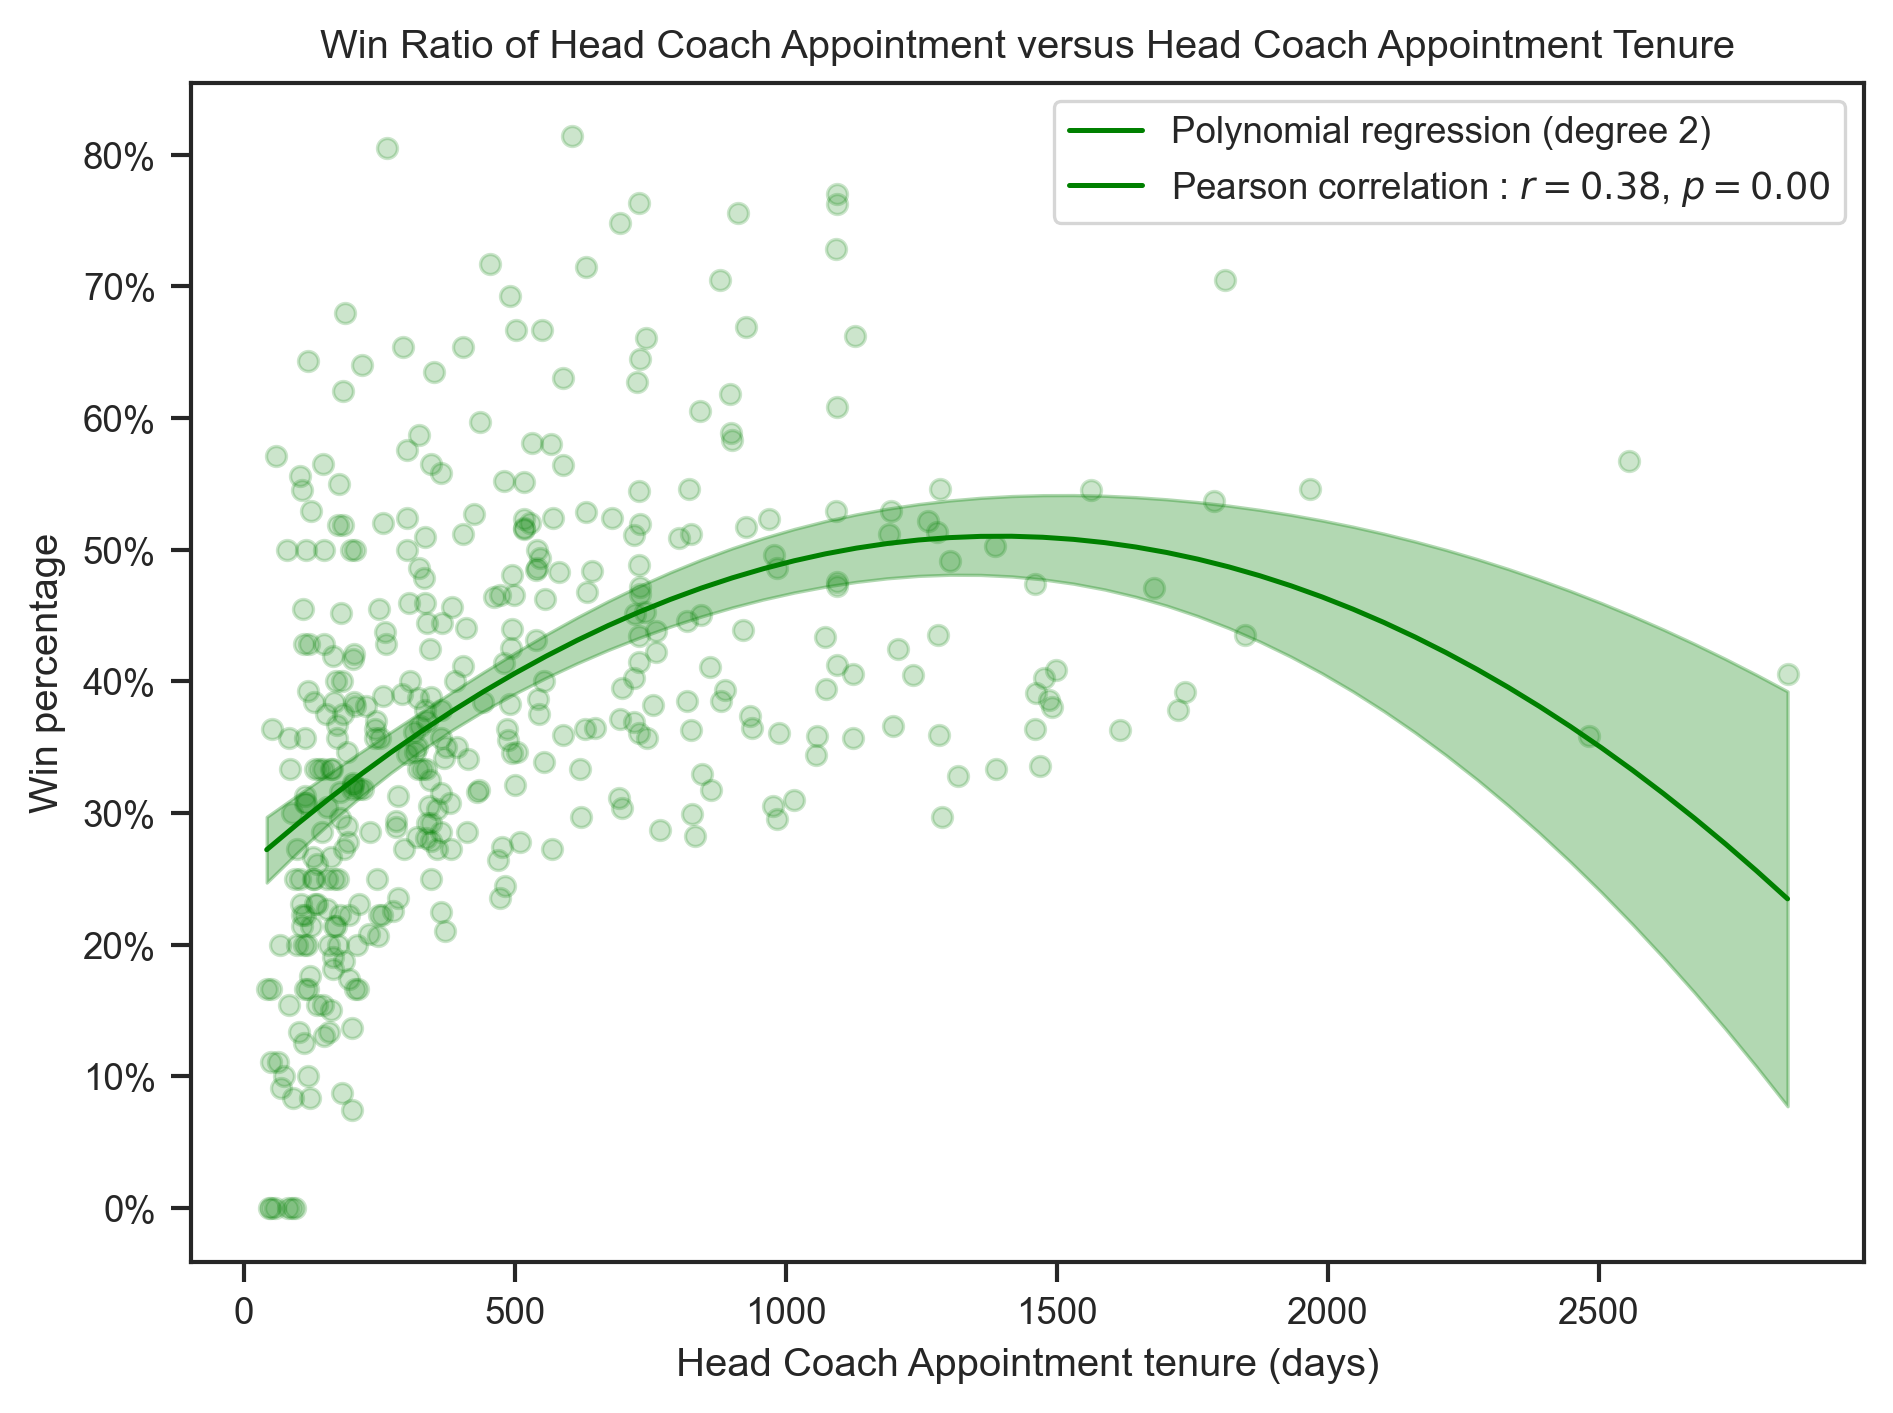

In [6]:
# | label: hc_win_ratio_over_days
create_polynomial_regression_plot(
    head_coach,
    "Tenure",
    "WinPercentage",
    "Win",
    "green",
    title.format("Win"),
    x_label,
    degree=2,
)

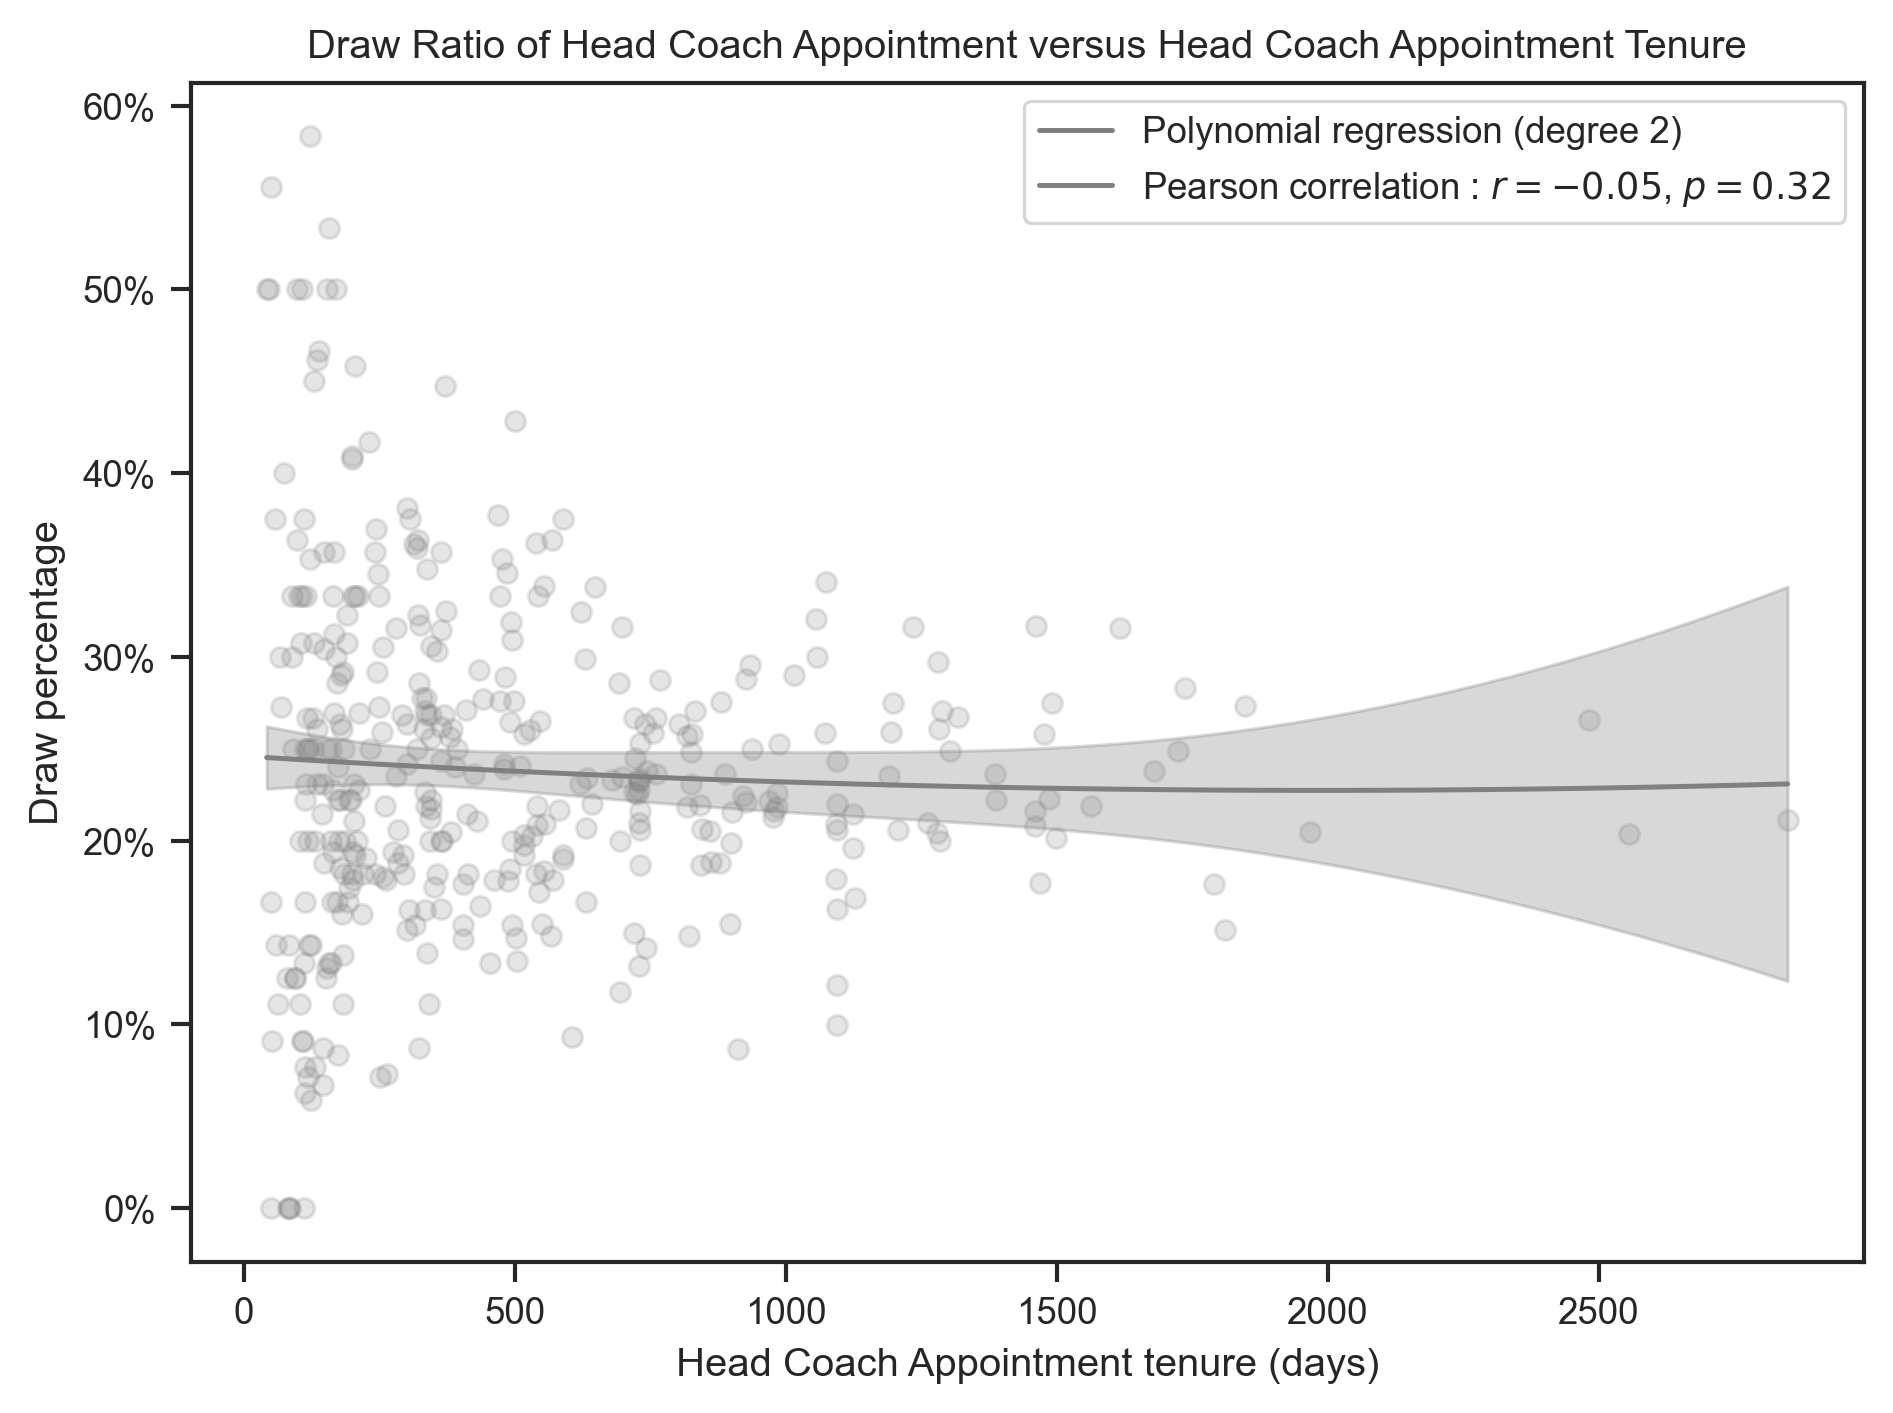

In [7]:
# | label: hc_draw_ratio_over_days
create_polynomial_regression_plot(
    head_coach,
    "Tenure",
    "DrawPercentage",
    "Draw",
    "gray",
    title.format("Draw"),
    x_label,
    degree=2,
)

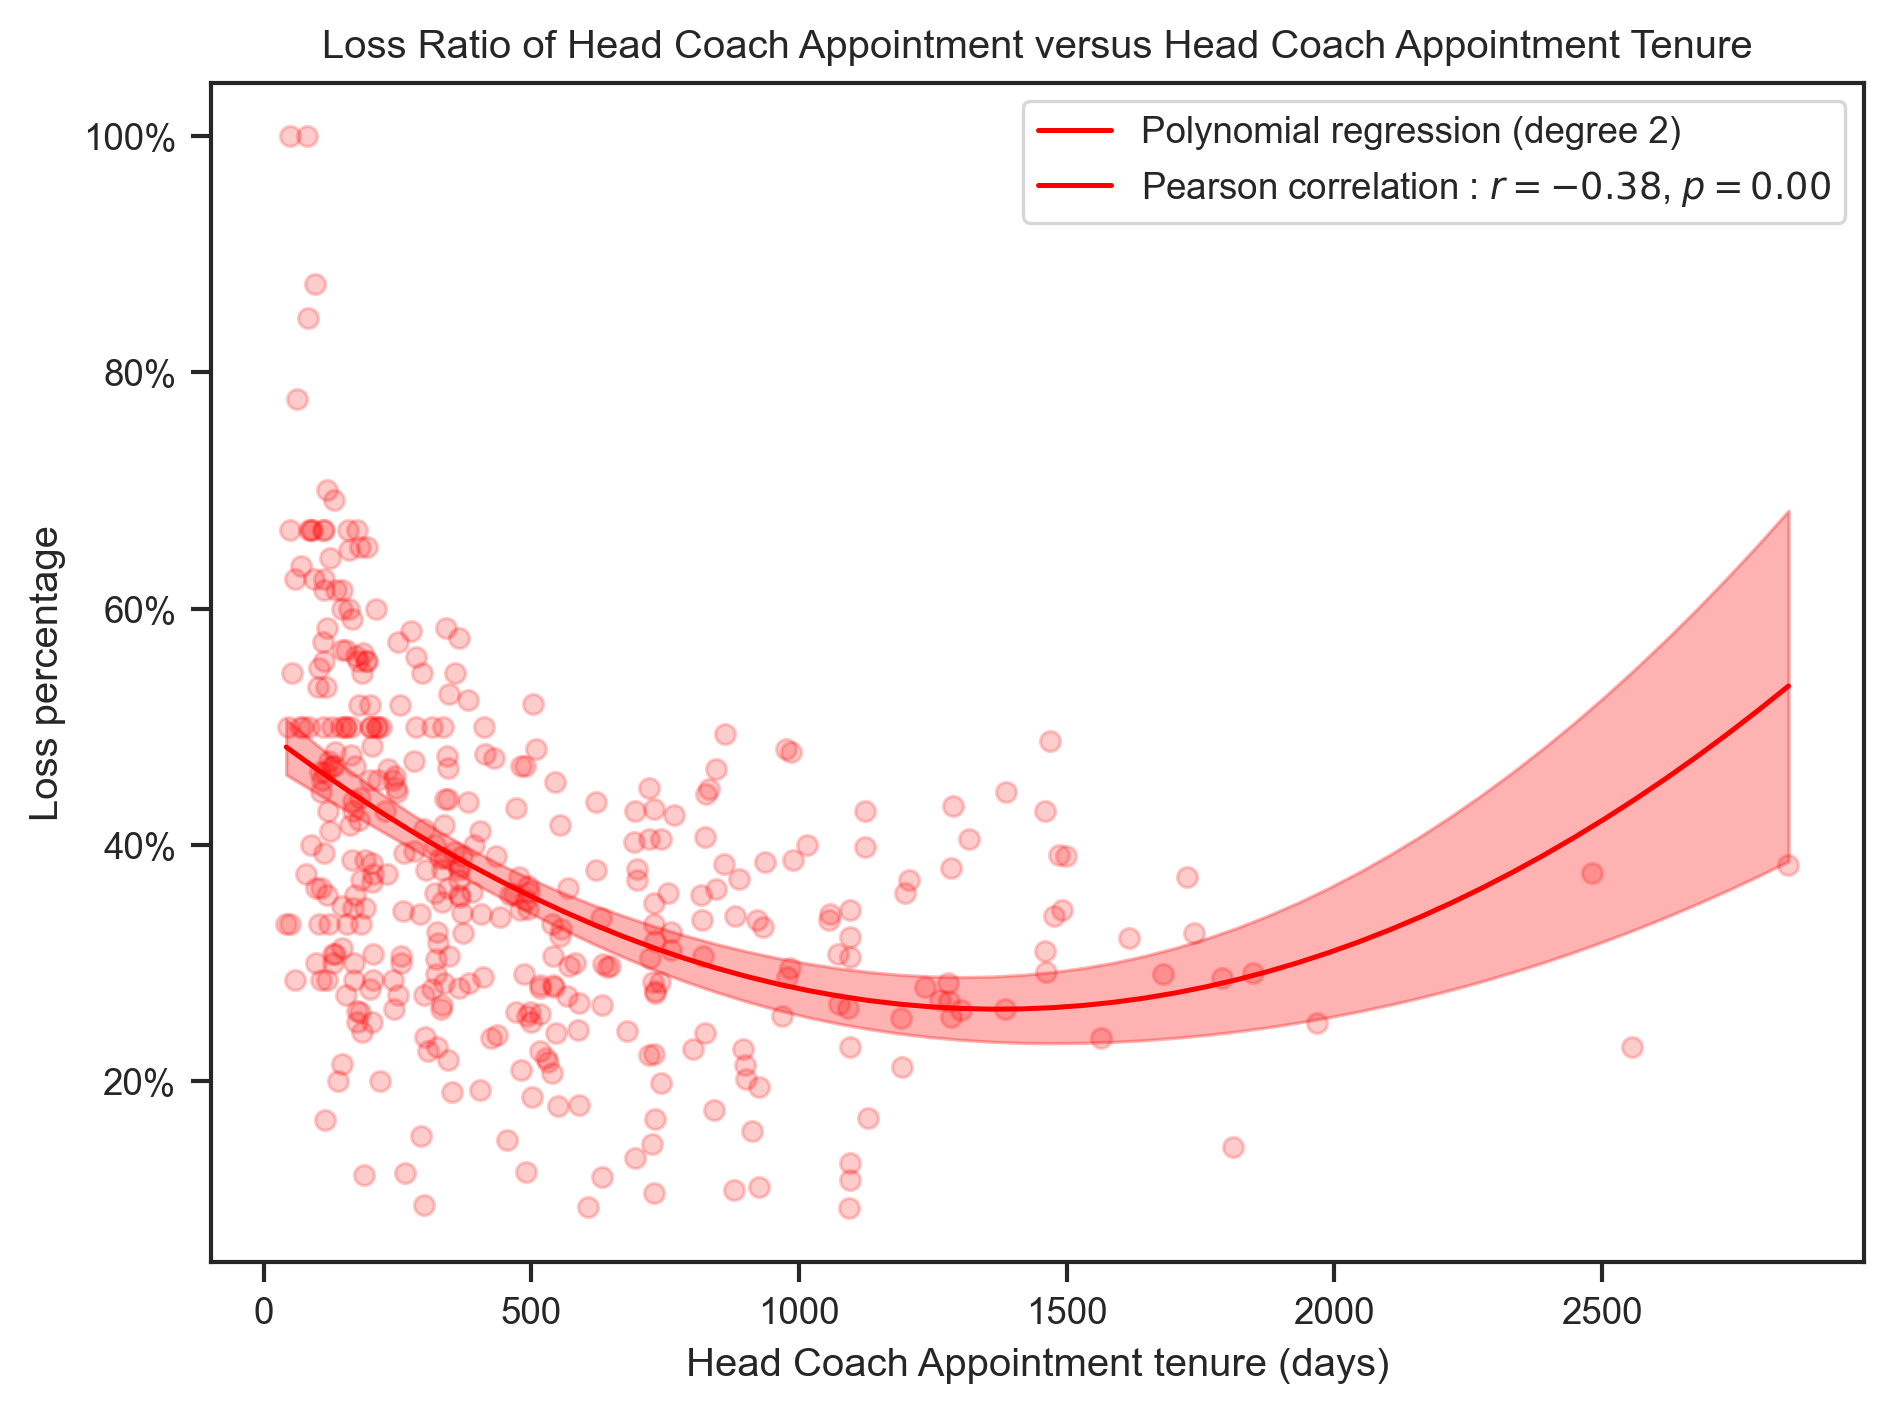

In [8]:
# | label: hc_loss_ratio_over_days
create_polynomial_regression_plot(
    head_coach,
    "Tenure",
    "LossPercentage",
    "Loss",
    "red",
    title.format("Loss"),
    x_label,
    degree=2,
)

#### Relation between Clubs Results and Number of Head Coaches

In [9]:
club_results = head_coach.groupby("Team").agg(
    {
        "Wins": "sum",
        "Draws": "sum",
        "Losses": "sum",
        "Matches": "sum",
        "HeadCoach": "count",
    }
)
club_results = club_results.rename(columns={"HeadCoach": "CoachCount"})
club_results["WinPercentage"] = club_results["Wins"] / club_results["Matches"] * 100
club_results["DrawPercentage"] = club_results["Draws"] / club_results["Matches"] * 100
club_results["LossPercentage"] = club_results["Losses"] / club_results["Matches"] * 100

title = "{} Ratio of Clubs versus Number of Head Coaches Appointment (2015-2023)"
x_label = "Number of Head Coach Appointment per Club"

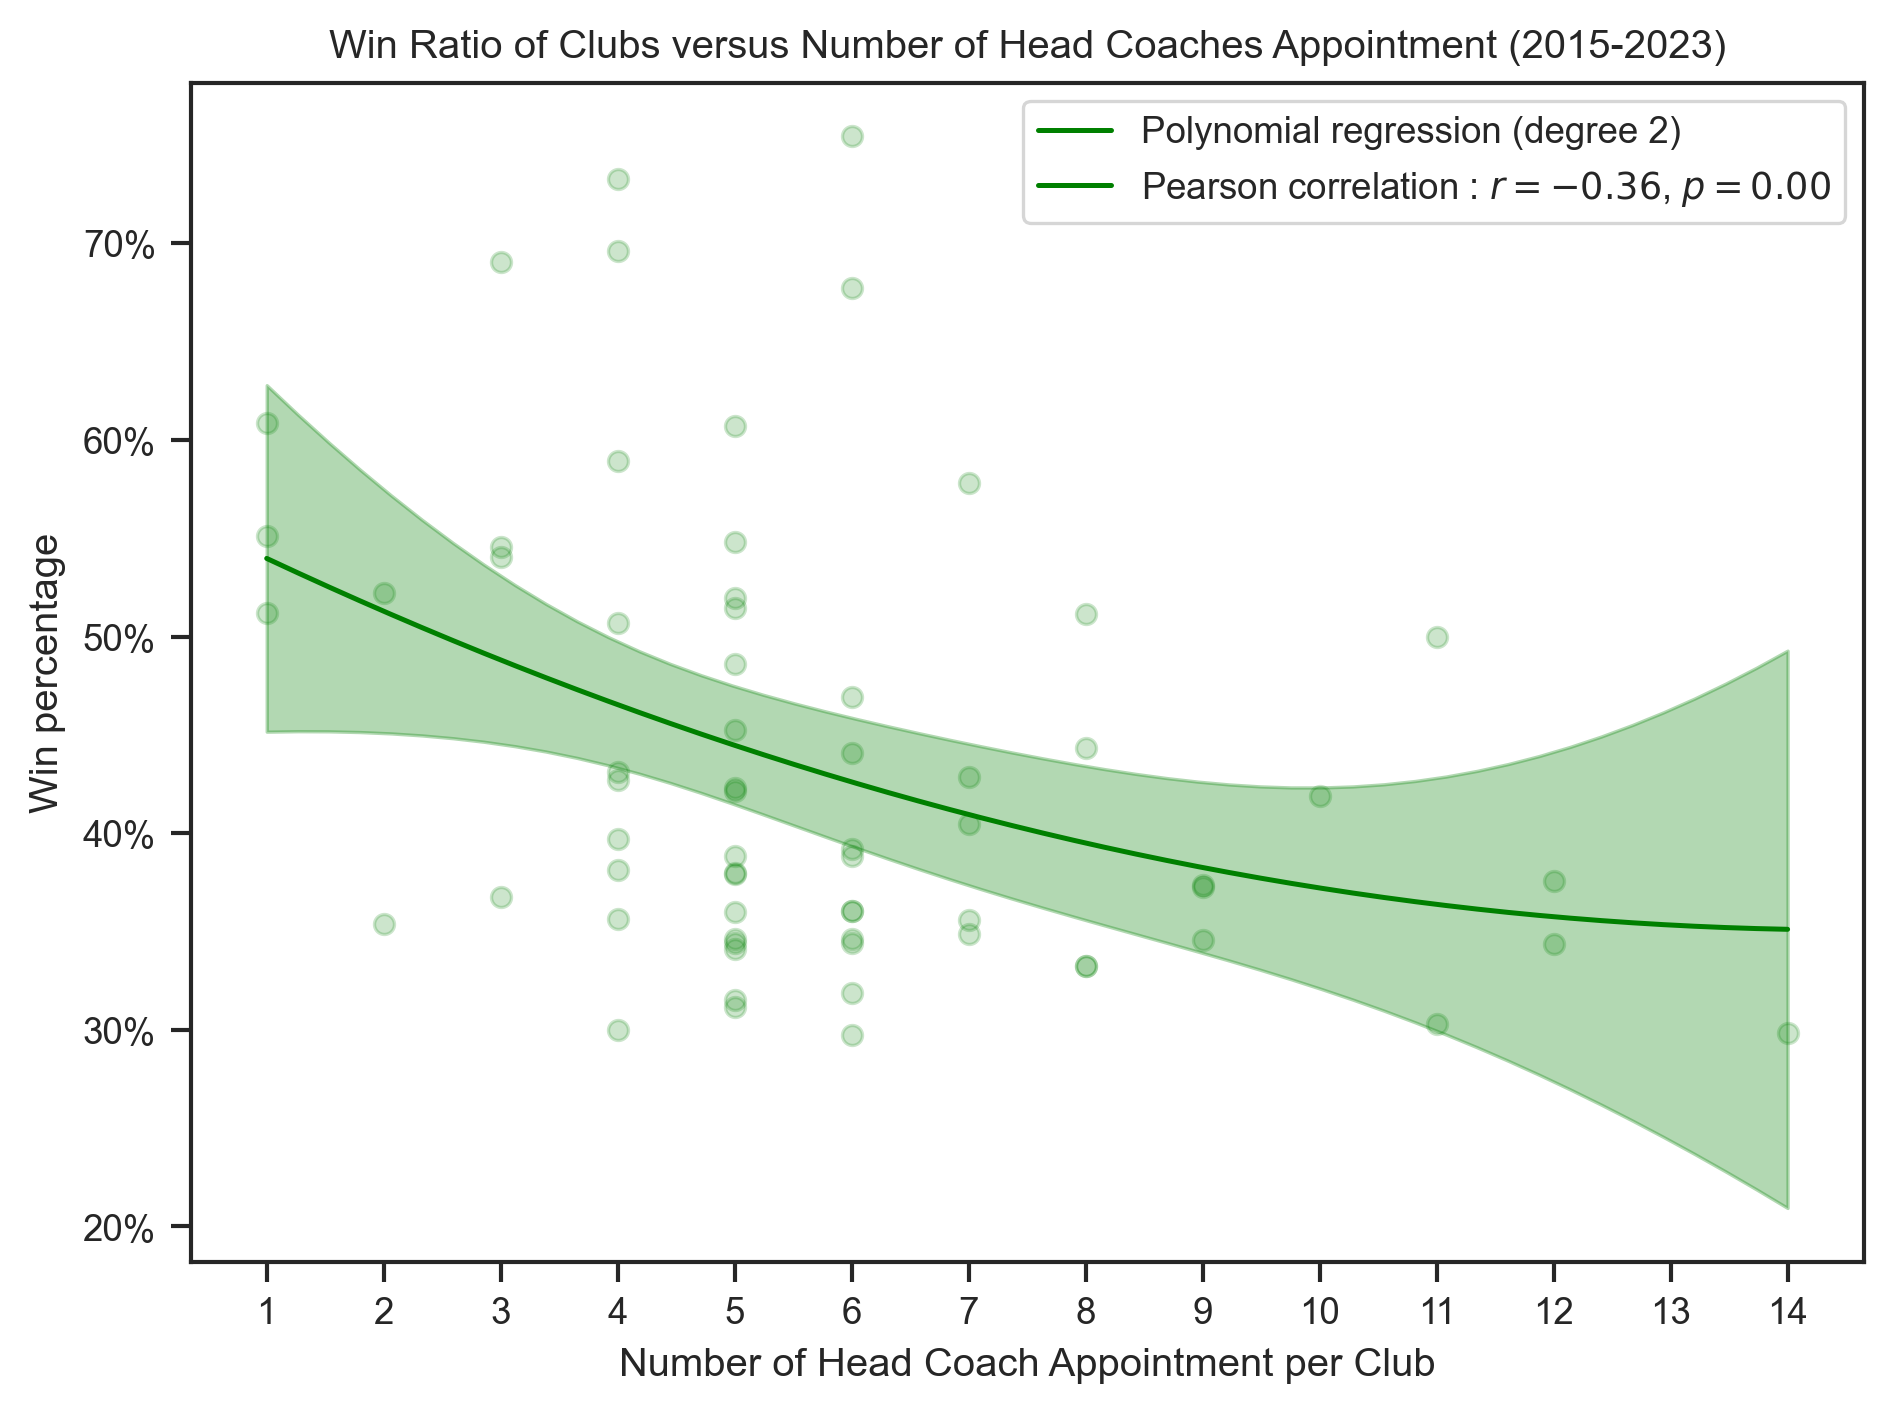

In [10]:
# | label: club_win_ratio_over_coach_count
create_polynomial_regression_plot(
    club_results,
    "CoachCount",
    "WinPercentage",
    "Win",
    "green",
    title.format("Win"),
    x_label,
    degree=2,
    integer_ticks=True,
)

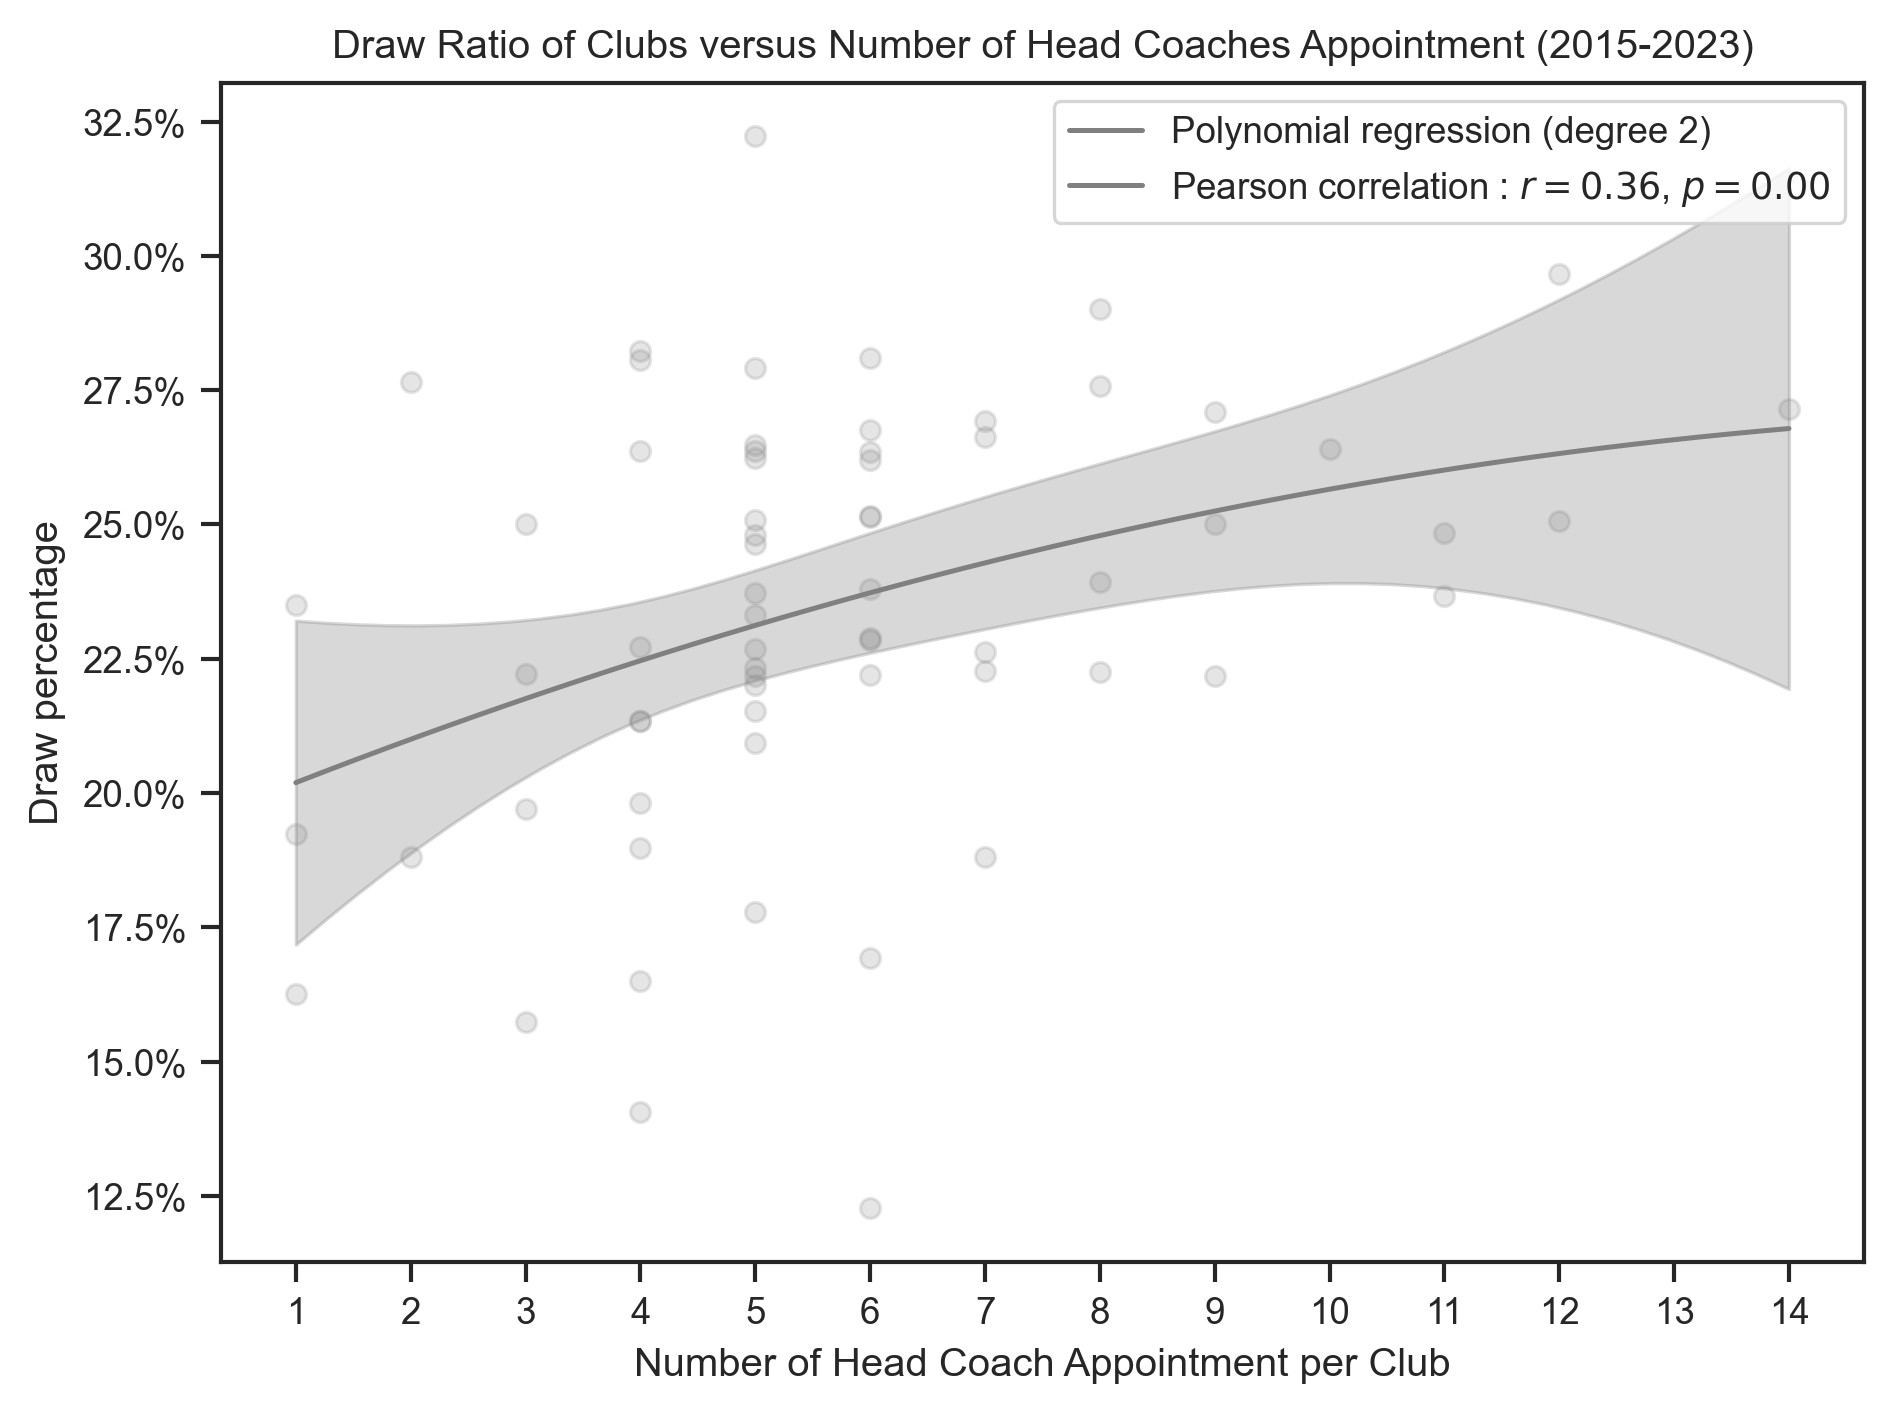

In [11]:
# | label: club_draw_ratio_over_coach_count
create_polynomial_regression_plot(
    club_results,
    "CoachCount",
    "DrawPercentage",
    "Draw",
    "gray",
    title.format("Draw"),
    x_label,
    degree=2,
    integer_ticks=True,
)

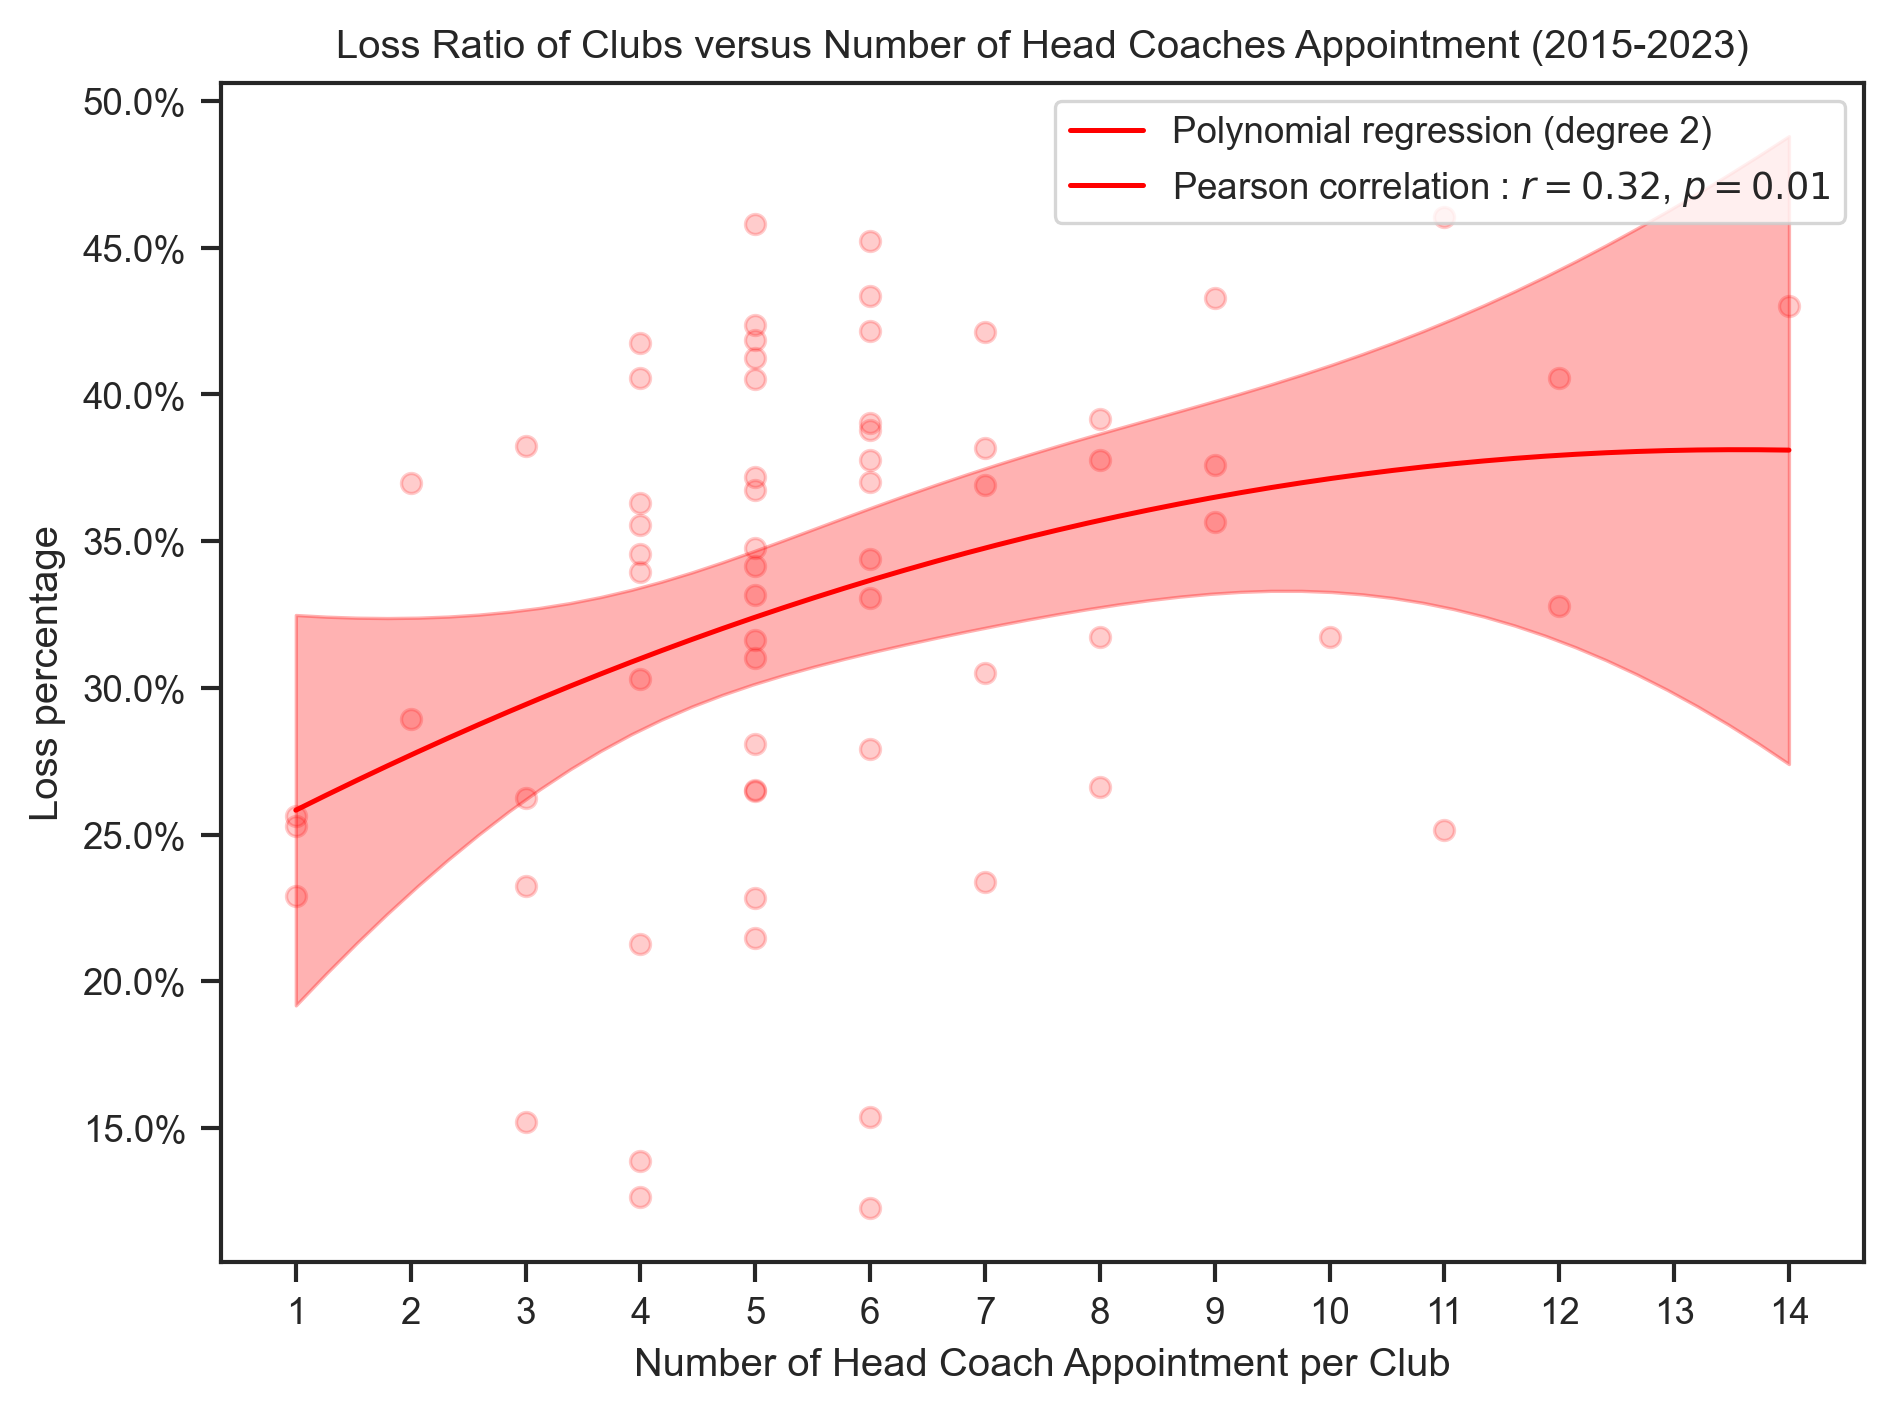

In [12]:
# | label: club_loss_ratio_over_coach_count
create_polynomial_regression_plot(
    club_results,
    "CoachCount",
    "LossPercentage",
    "Loss",
    "red",
    title.format("Loss"),
    x_label,
    degree=2,
    integer_ticks=True,
)

#### Relation between Head Coach Aggregated Performance versus Total Number of Clubs Head Coaches Worked for

In [13]:
# Plot of wins, draw and losses percentage over number of club head coach has been

hc_results = (
    head_coach.groupby("HeadCoach")
    .agg(
        {
            "Matches": "sum",
            "Wins": "sum",
            "Draws": "sum",
            "Losses": "sum",
            "Team": "count",
        }
    )
    .reset_index()
)
hc_results = hc_results.rename(columns={"Team": "ClubCount"})
hc_results["WinPercentage"] = hc_results["Wins"] / hc_results["Matches"] * 100
hc_results["DrawPercentage"] = hc_results["Draws"] / hc_results["Matches"] * 100
hc_results["LossPercentage"] = hc_results["Losses"] / hc_results["Matches"] * 100

title = (
    "{} Ratio of Head Coach Career versus Number of Head Coach Appointments (2015-2023)"
)
x_label = "Number of Head Coach Appointments"

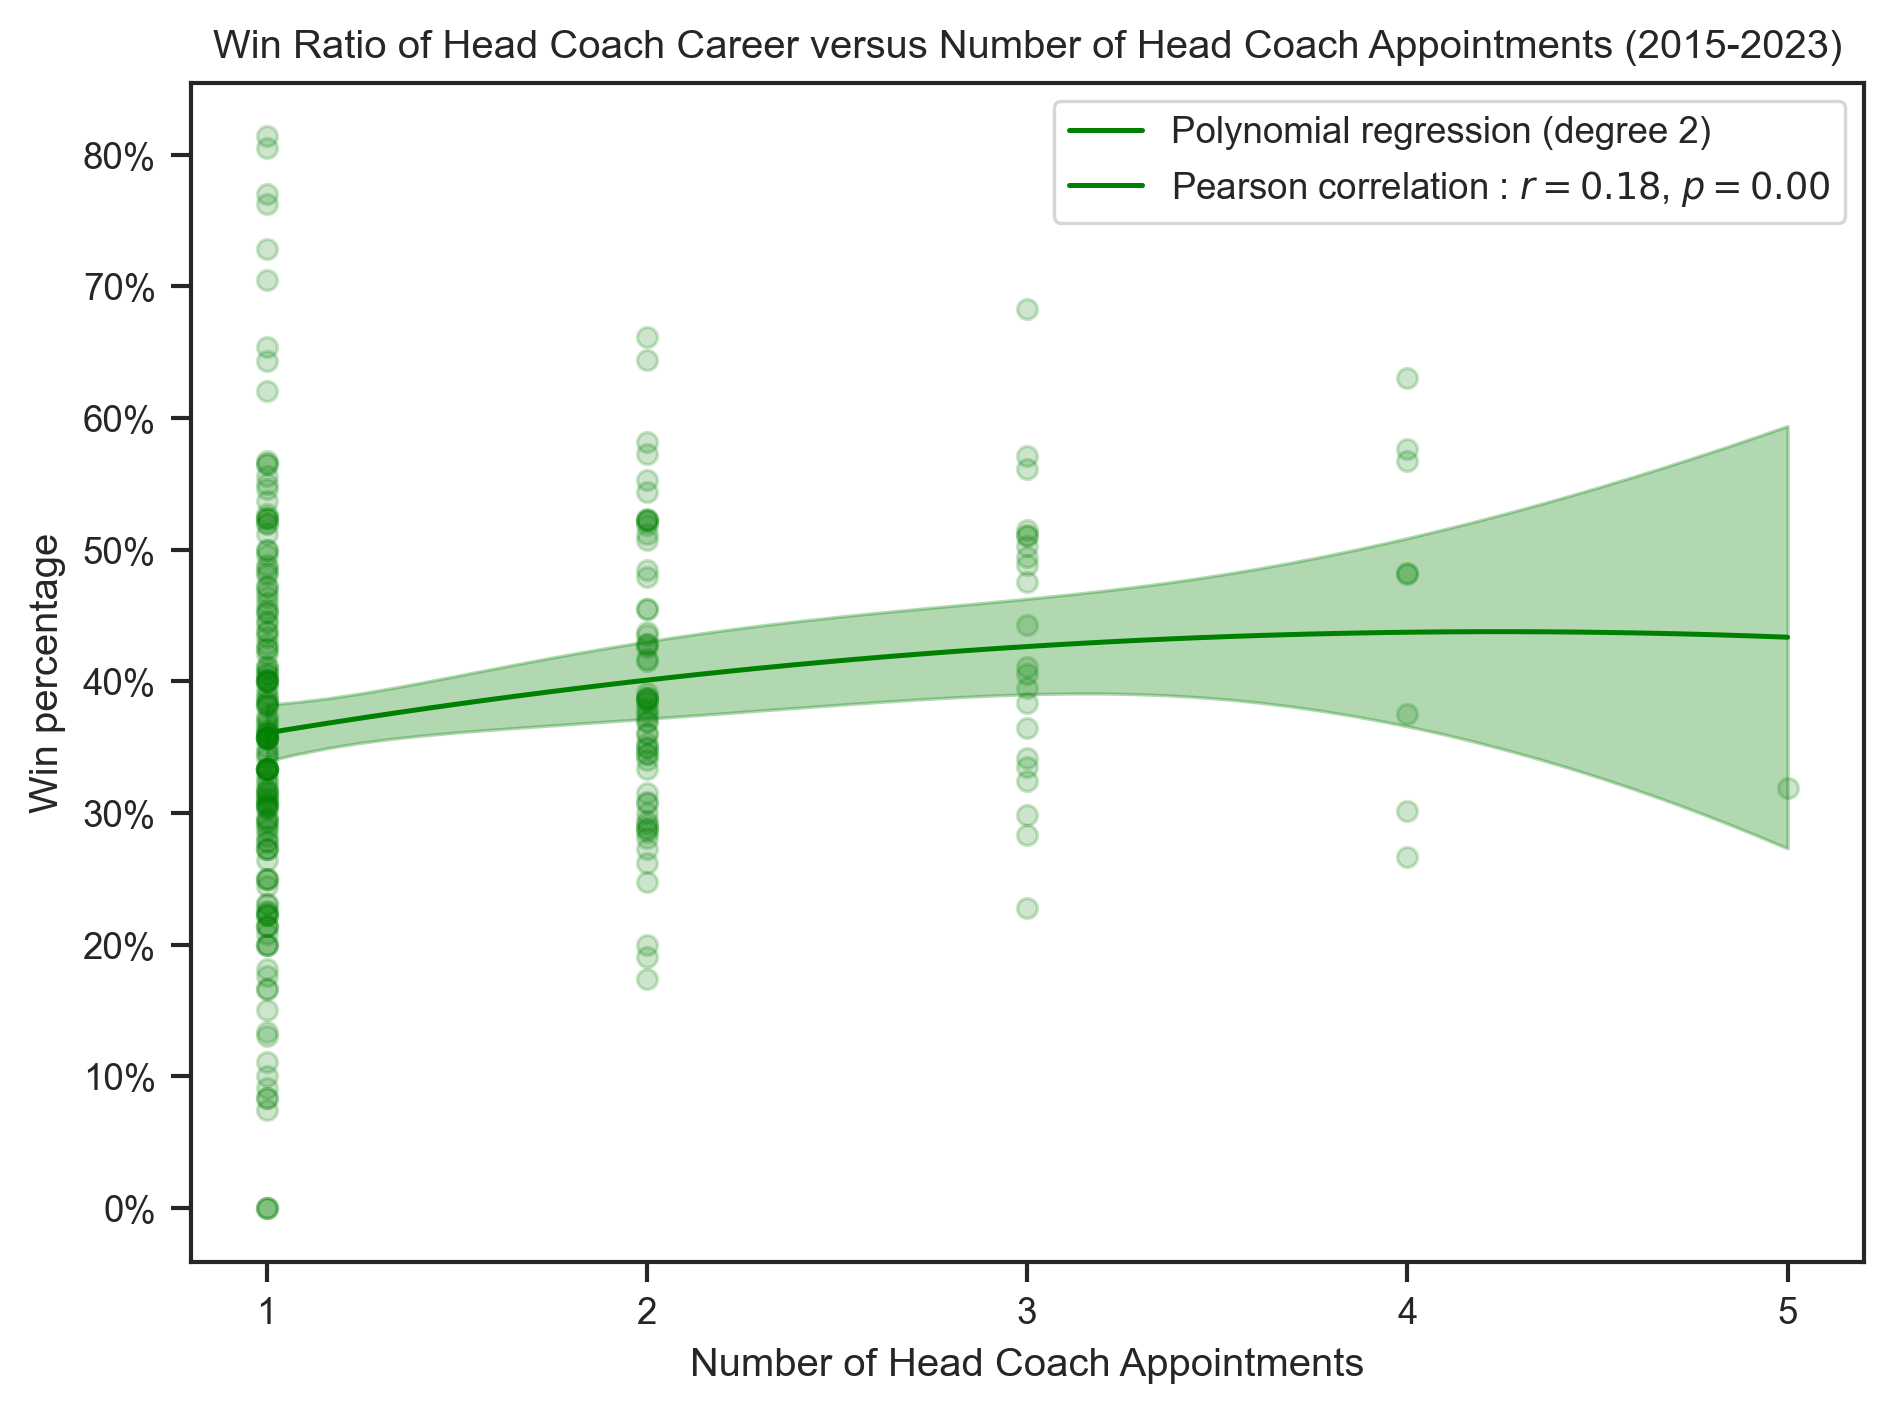

In [14]:
# | label: hc_win_ratio_over_club_count
create_polynomial_regression_plot(
    hc_results,
    "ClubCount",
    "WinPercentage",
    "Win",
    "green",
    title.format("Win"),
    x_label,
    degree=2,
    integer_ticks=True,
)

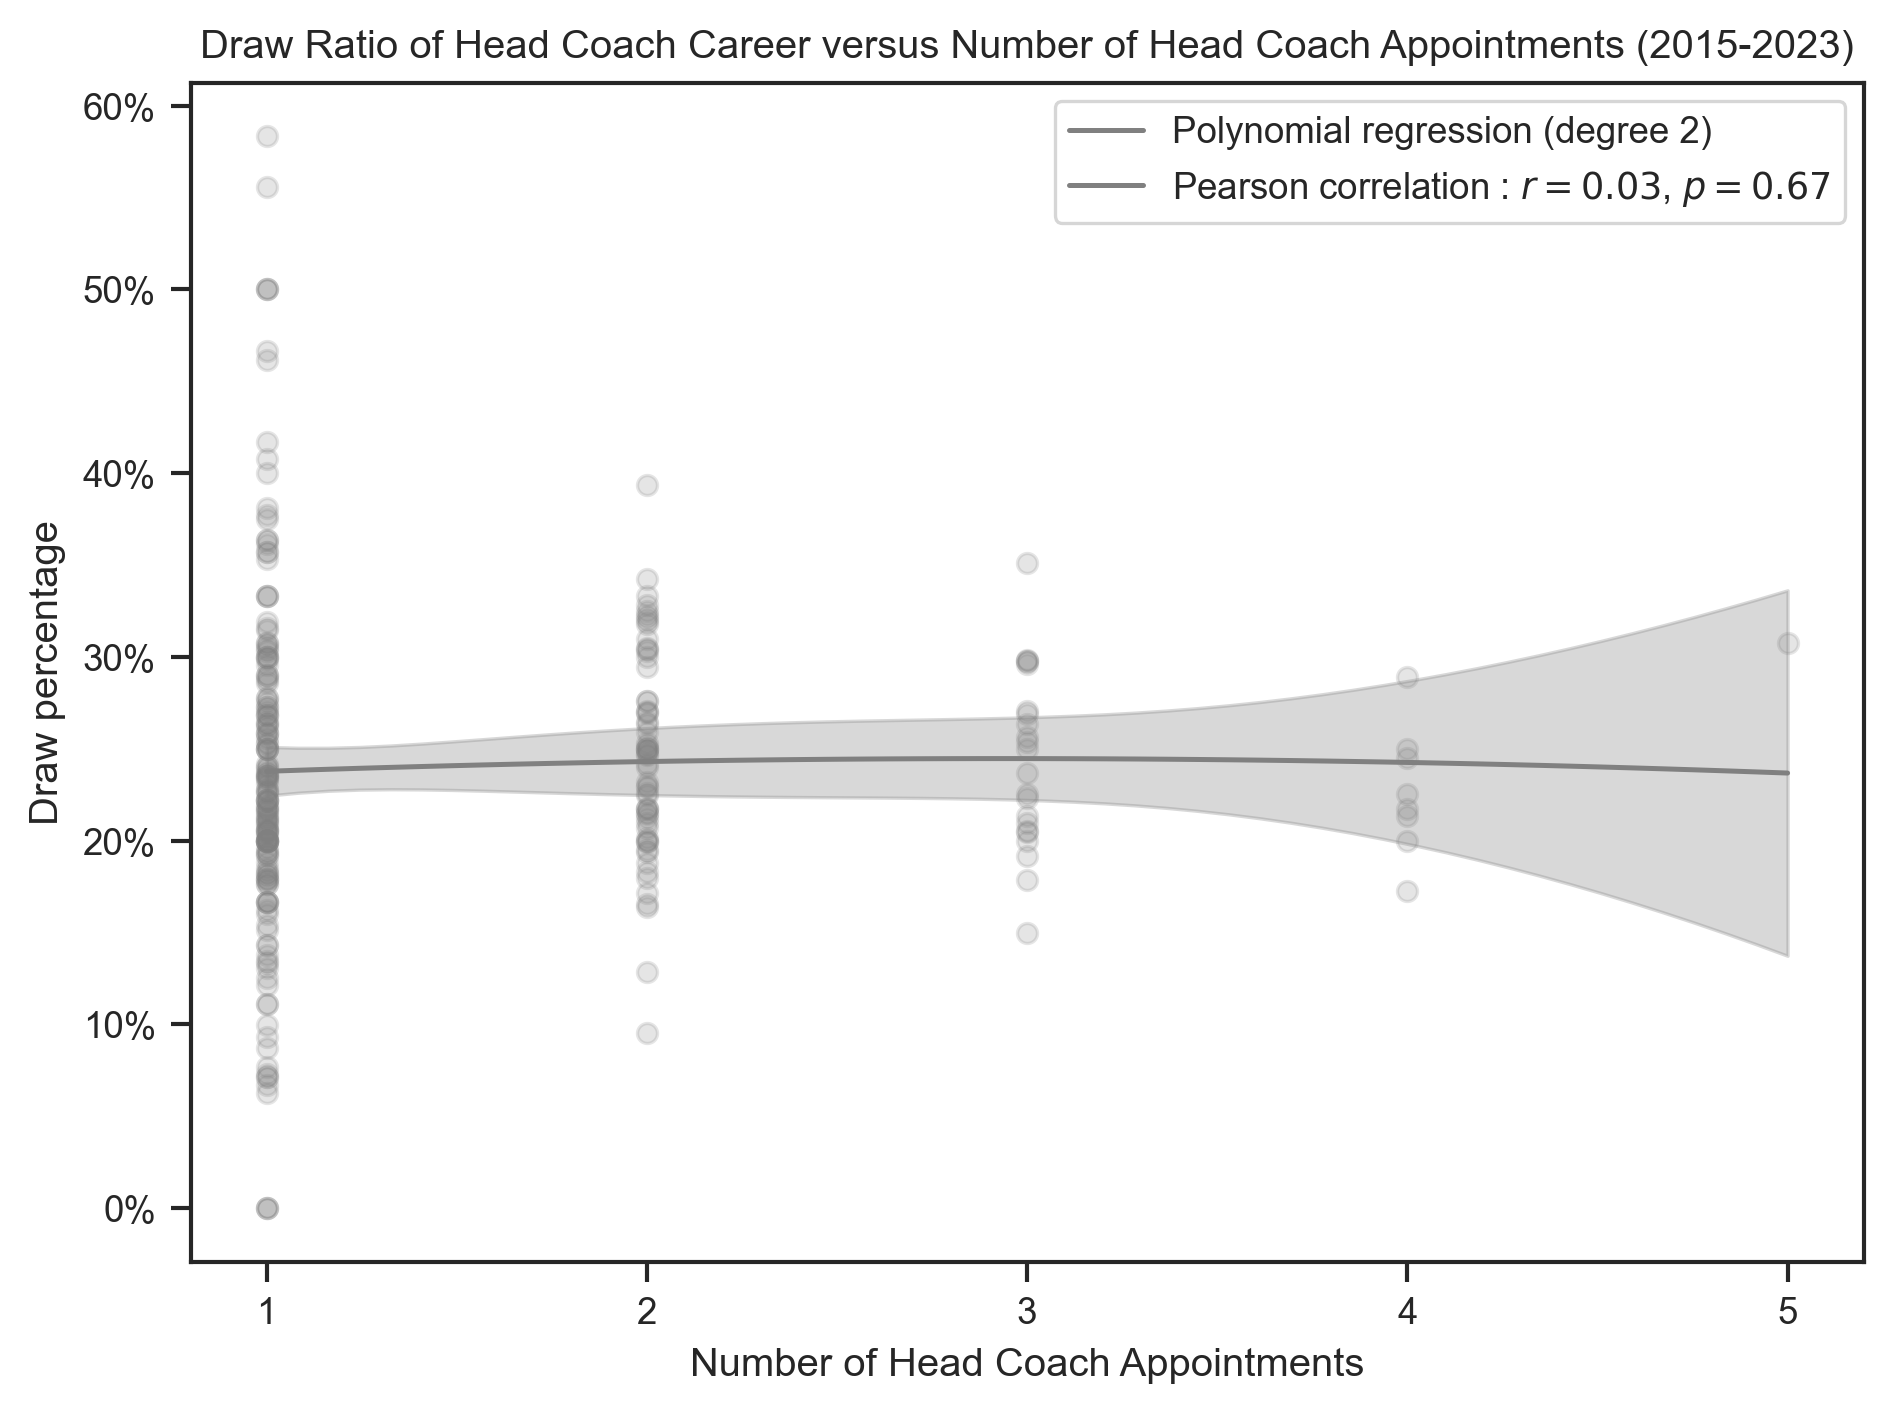

In [15]:
# | label: hc_draw_ratio_over_club_count
create_polynomial_regression_plot(
    hc_results,
    "ClubCount",
    "DrawPercentage",
    "Draw",
    "gray",
    title.format("Draw"),
    x_label,
    degree=2,
    integer_ticks=True,
)

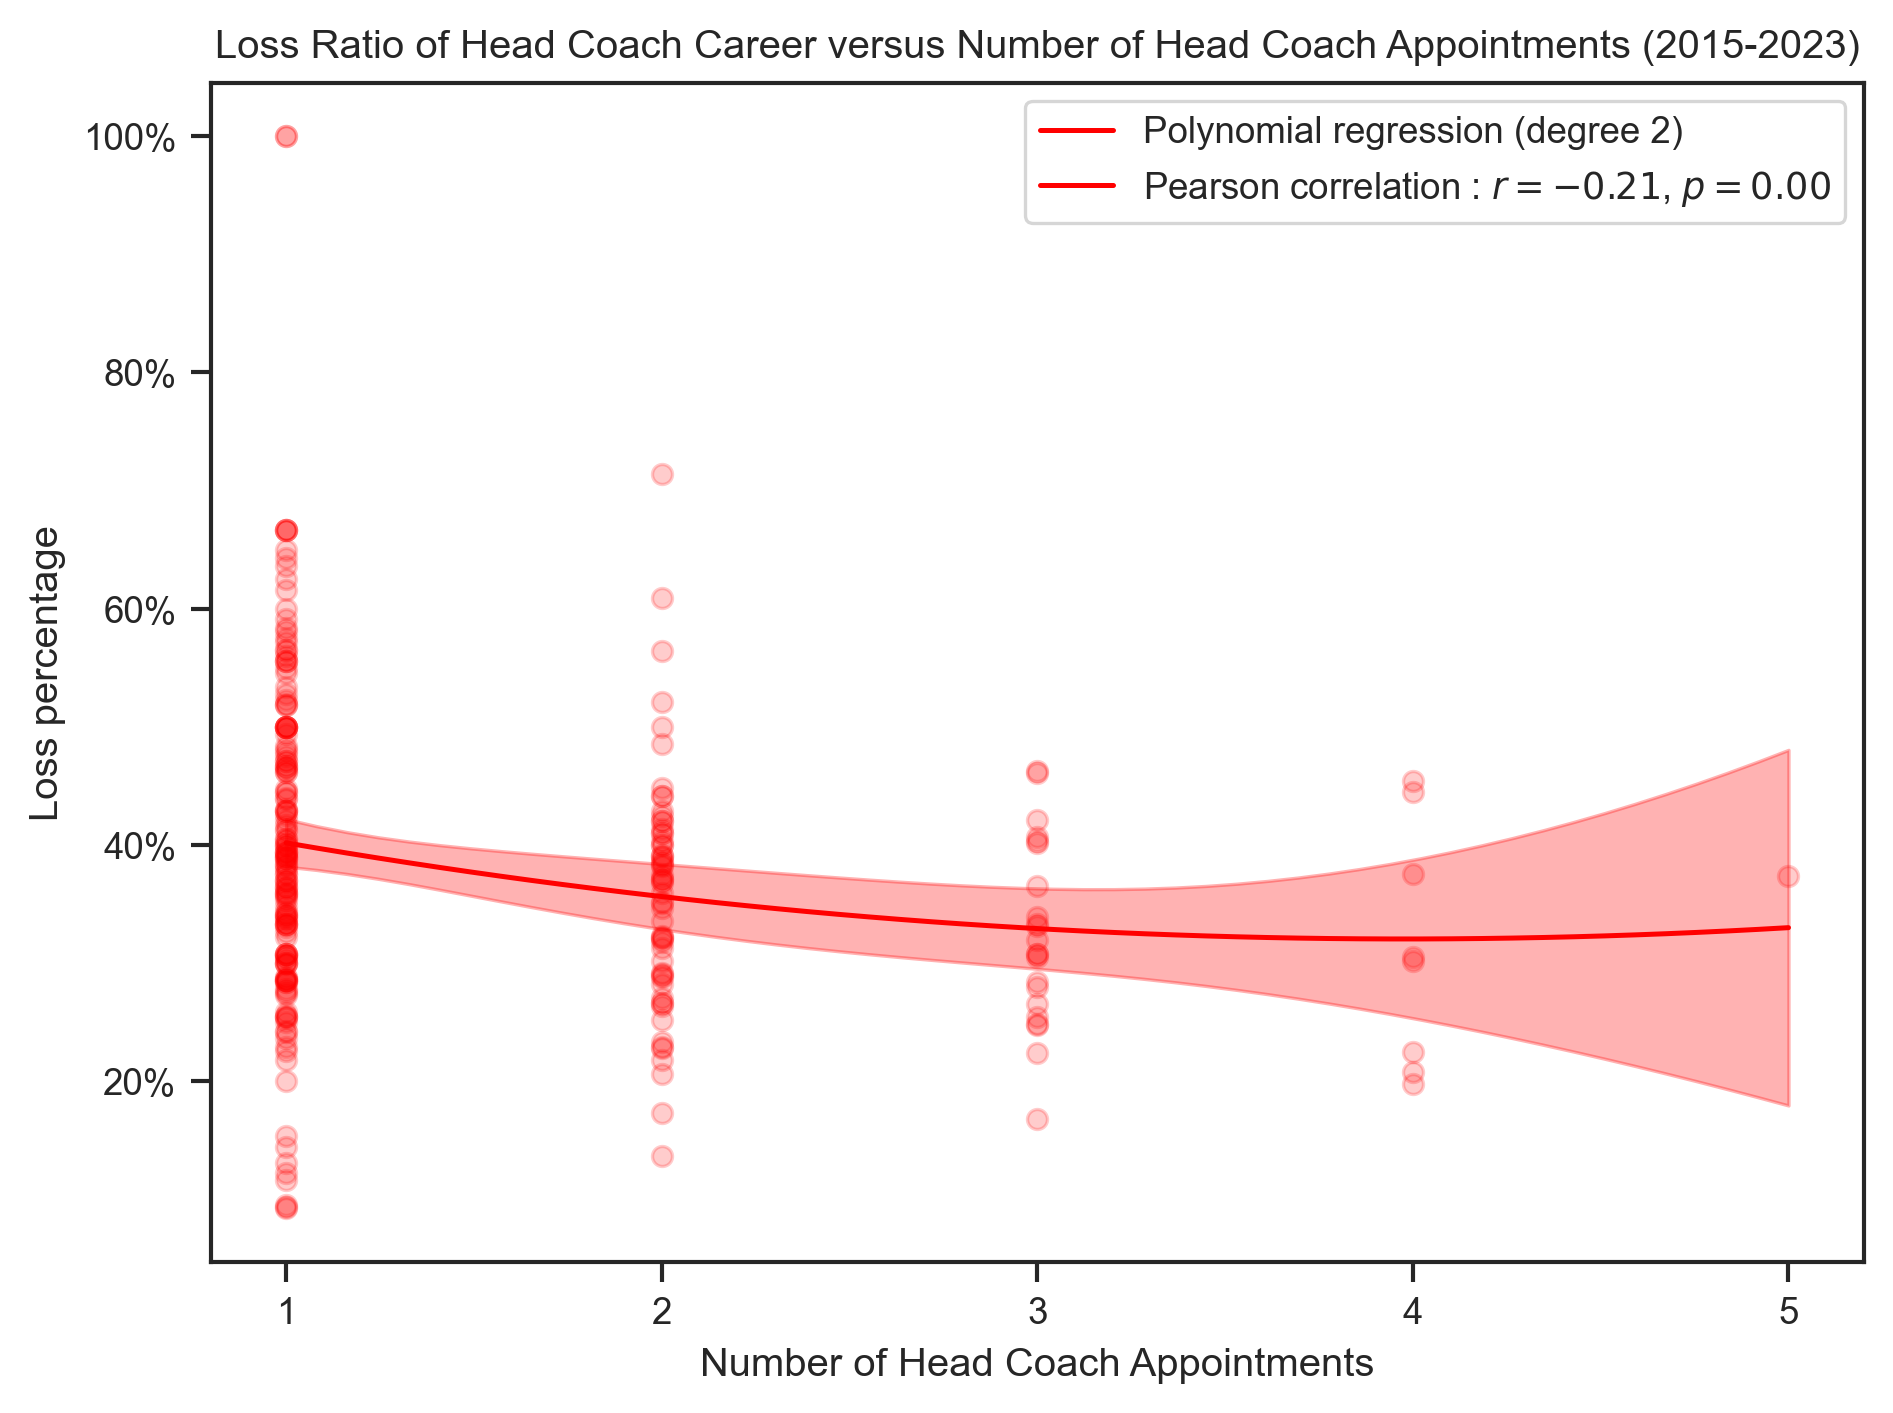

In [16]:
# | label: hc_loss_ratio_over_club_count
create_polynomial_regression_plot(
    hc_results,
    "ClubCount",
    "LossPercentage",
    "Loss",
    "red",
    title.format("Loss"),
    x_label,
    degree=2,
    integer_ticks=True,
)

#### Relation between Head Coach Appointments Results versus Head Coach Appointments Counts

In [17]:
title = "{} Ratio of Head Coaches Appointments versus Head Coach Appointment Count (2015-2023)"
x_label = "Head Coach Appointment Count"

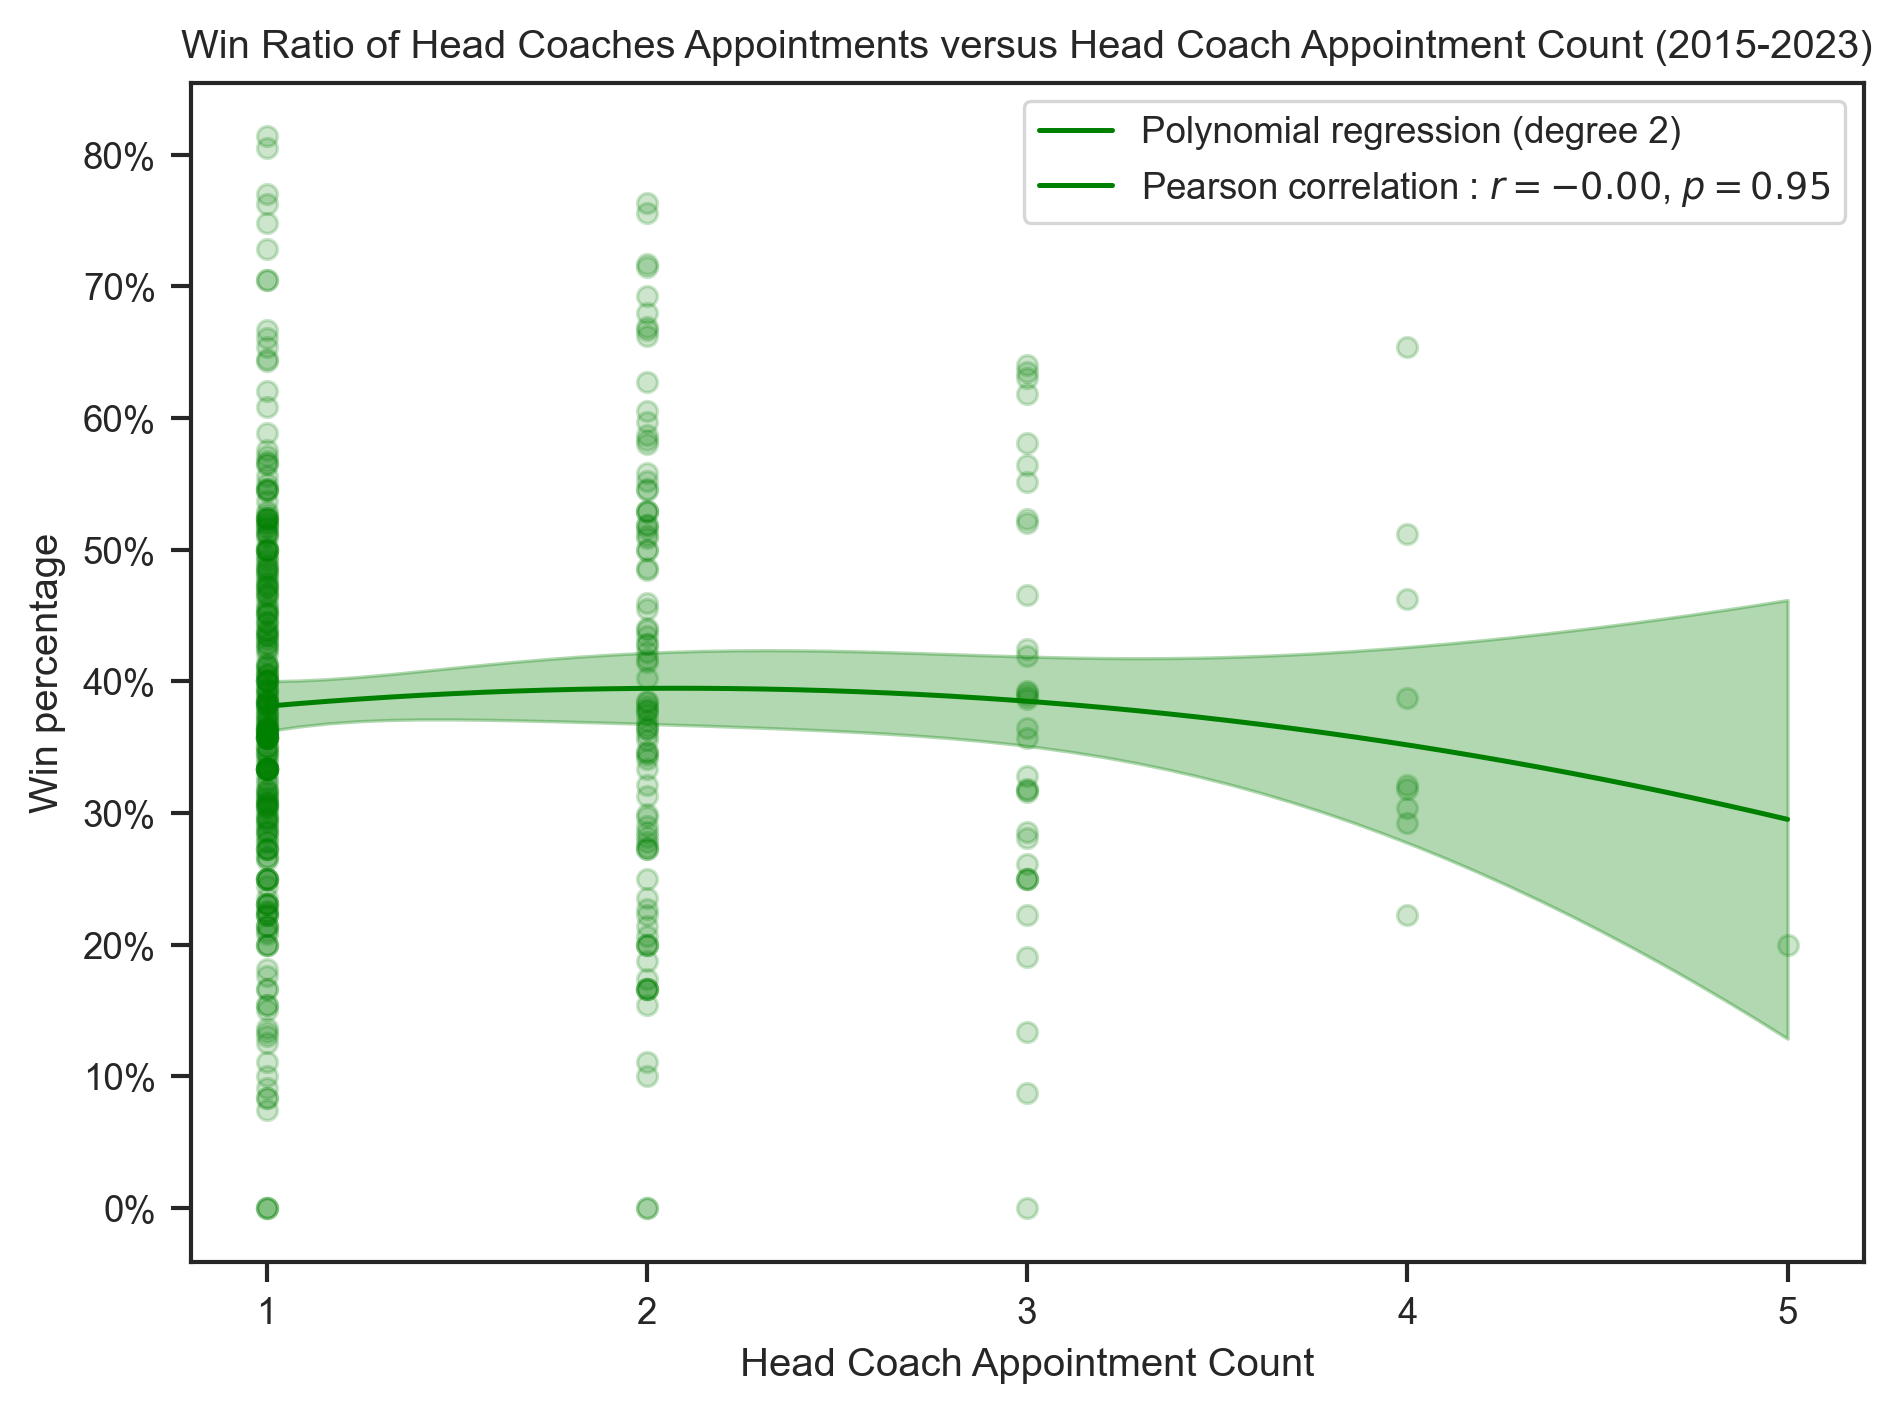

In [18]:
# | label: hc_win_vs_appointment_count
create_polynomial_regression_plot(
    head_coach,
    "AppointmentNumber",
    "WinPercentage",
    "Win",
    "green",
    title.format("Win"),
    x_label,
    degree=2,
    integer_ticks=True,
)

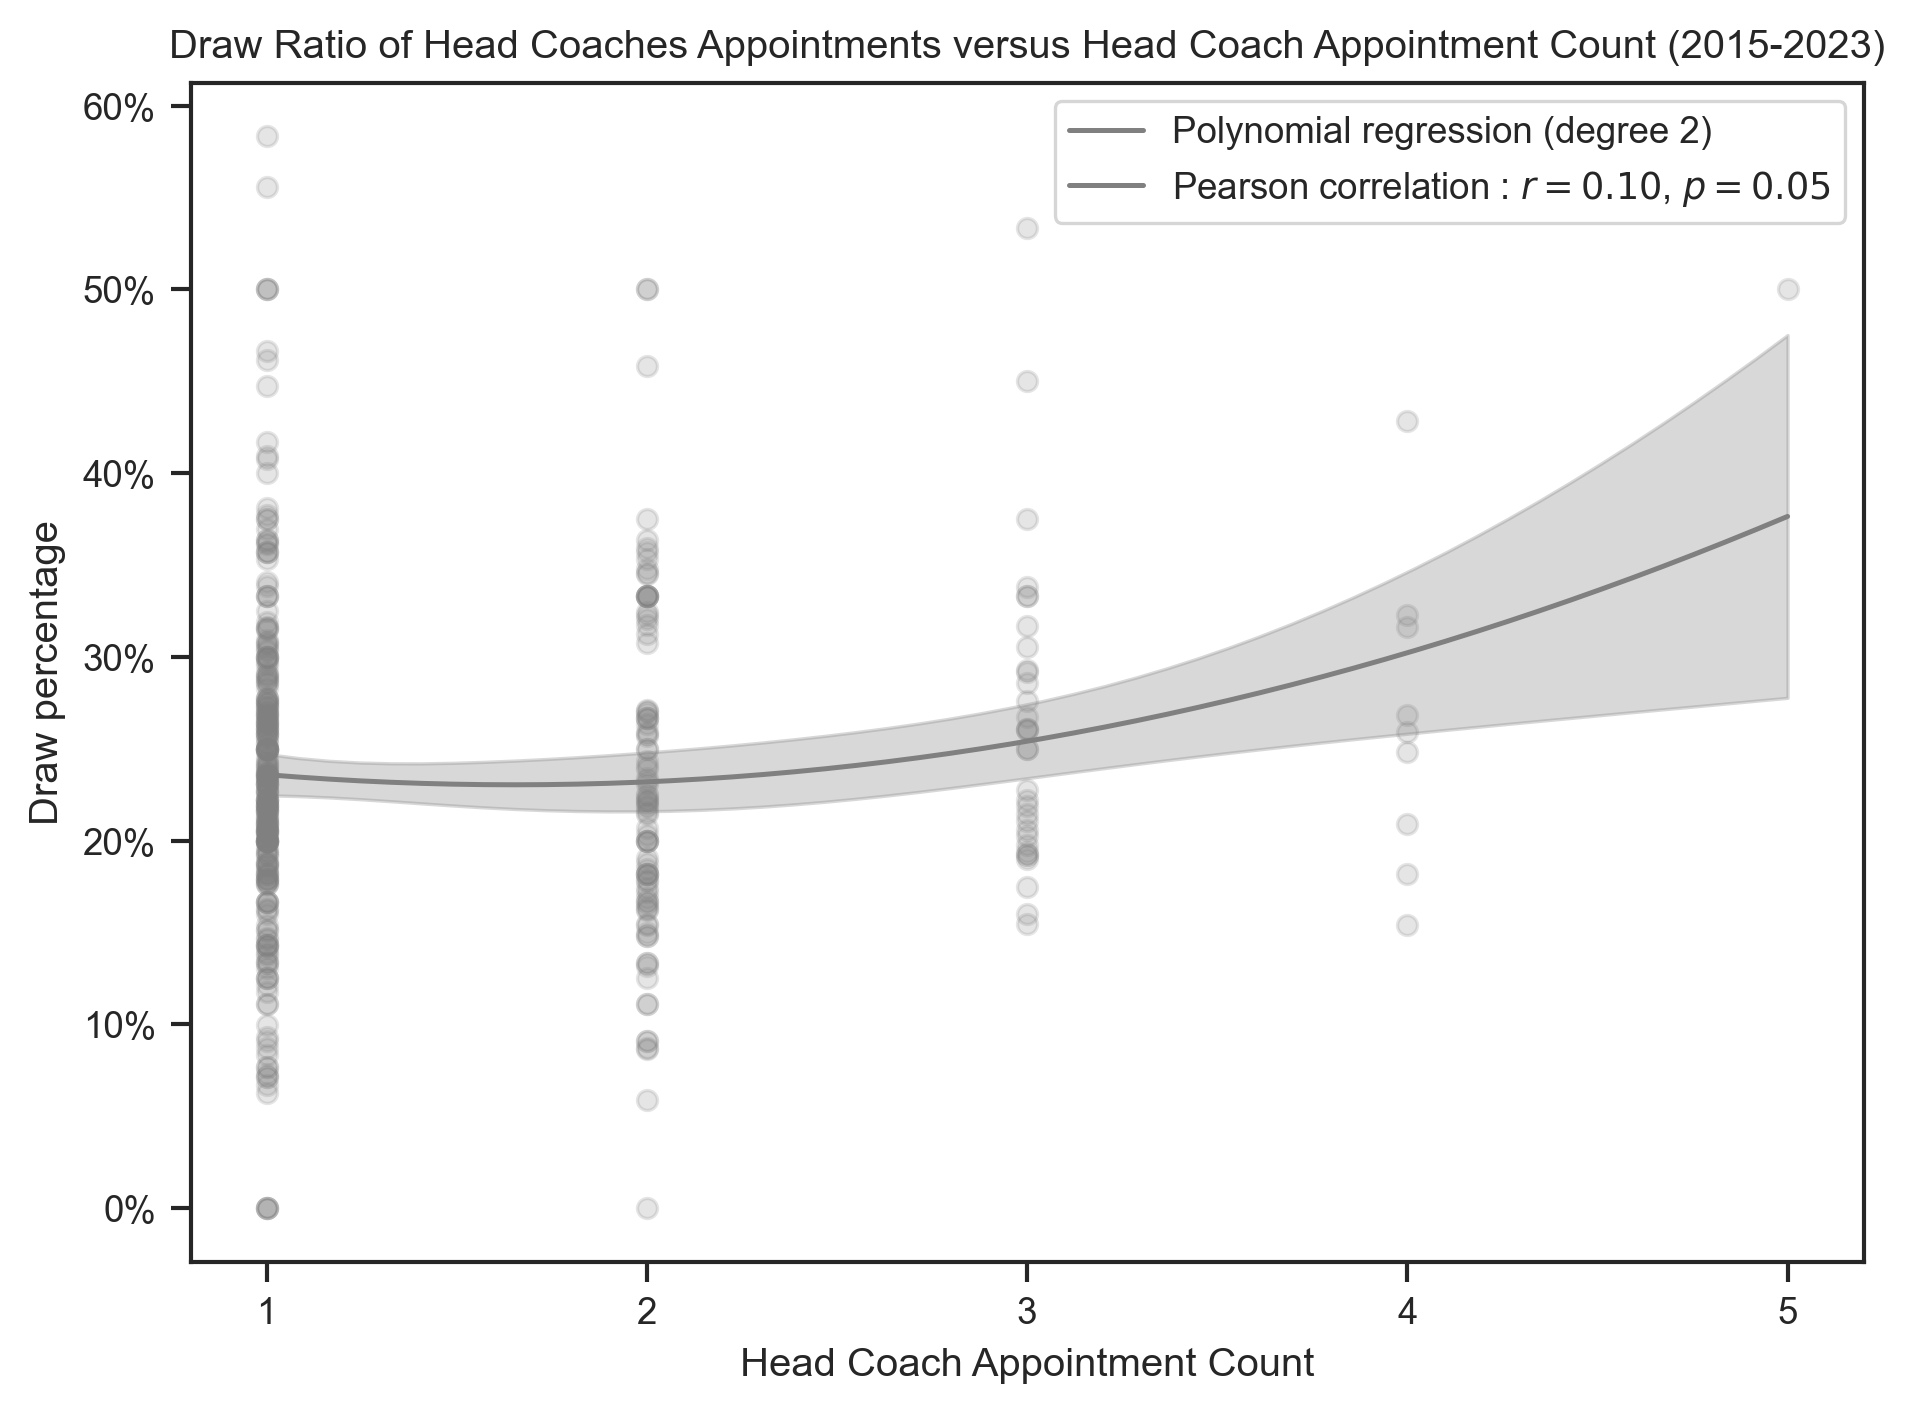

In [19]:
# | label: hc_draw_vs_appointment_count
create_polynomial_regression_plot(
    head_coach,
    "AppointmentNumber",
    "DrawPercentage",
    "Draw",
    "gray",
    title.format("Draw"),
    x_label,
    degree=2,
    integer_ticks=True,
)

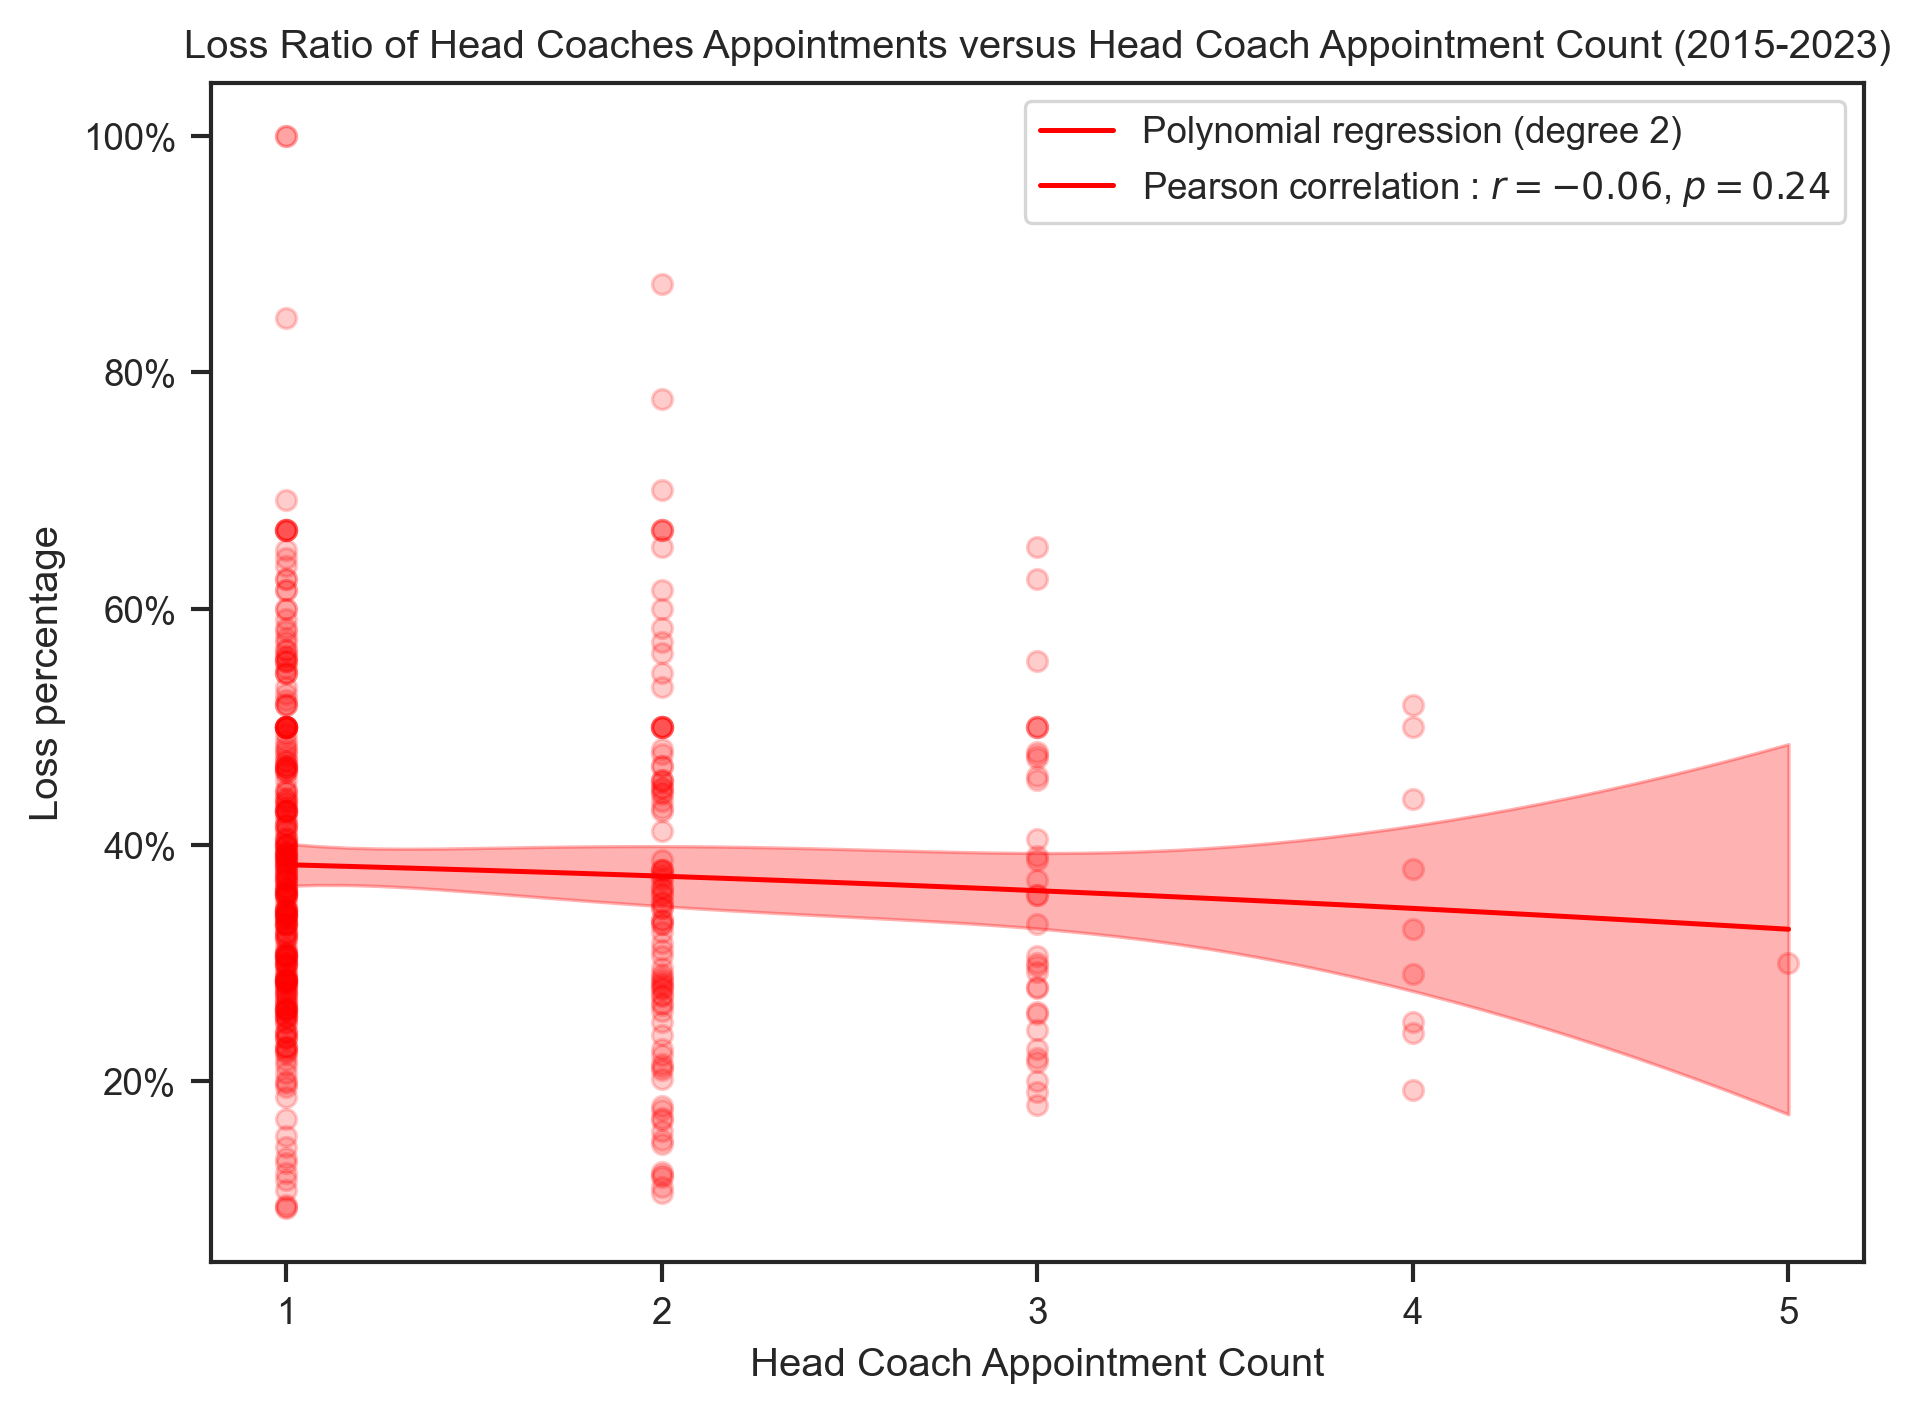

In [20]:
# | label: hc_loss_vs_appointment_count
create_polynomial_regression_plot(
    head_coach,
    "AppointmentNumber",
    "LossPercentage",
    "Loss",
    "red",
    title.format("Loss"),
    x_label,
    degree=2,
    integer_ticks=True,
)

### Loading data

In [21]:
# | label: joint_data
match_results = pd.read_csv(
    "data/match_results.csv", parse_dates=["Date"], dtype={"HeadCoach": "str"}
)
match_results.head()

,League,Country,Date,Team,Goals,Result,isHome,HeadCoach,DaysInPost
0,Premier League,England,2014-08-16,Manchester Utd,1.0,loss,True,Louis van Gaal,33.0
1,Premier League,England,2014-08-16,Arsenal,2.0,win,True,Arsène Wenger,6528.0
2,Premier League,England,2014-08-17,Liverpool,2.0,win,True,Brendan Rodgers,777.0
3,Premier League,England,2014-08-17,Newcastle Utd,0.0,loss,True,Alan Pardew,1347.0
4,Premier League,England,2014-11-01,Newcastle Utd,1.0,win,True,Alan Pardew,1423.0


### Relation between match outcomes and head coaches days in post during match

In [22]:
# Exclude rows where don't have information about head coach days in post during match
match_results = match_results.dropna(subset=["DaysInPost"])
# Exclude rows with DaysInPost more than 4000
match_results = match_results[match_results["DaysInPost"] <= 4000]
# The reason for this is that we have records of Arsenal head coach Arsene Wenger who has been in post for 22 years.
# Our data start date for matches is 2015. This makes some matches start with a head coach tenure of 5000 days.

match_results["Win"] = match_results["Result"].apply(lambda x: 1 if x == "win" else 0)
match_results["Loss"] = match_results["Result"].apply(lambda x: 1 if x == "loss" else 0)
match_results["Draw"] = match_results["Result"].apply(lambda x: 1 if x == "draw" else 0)

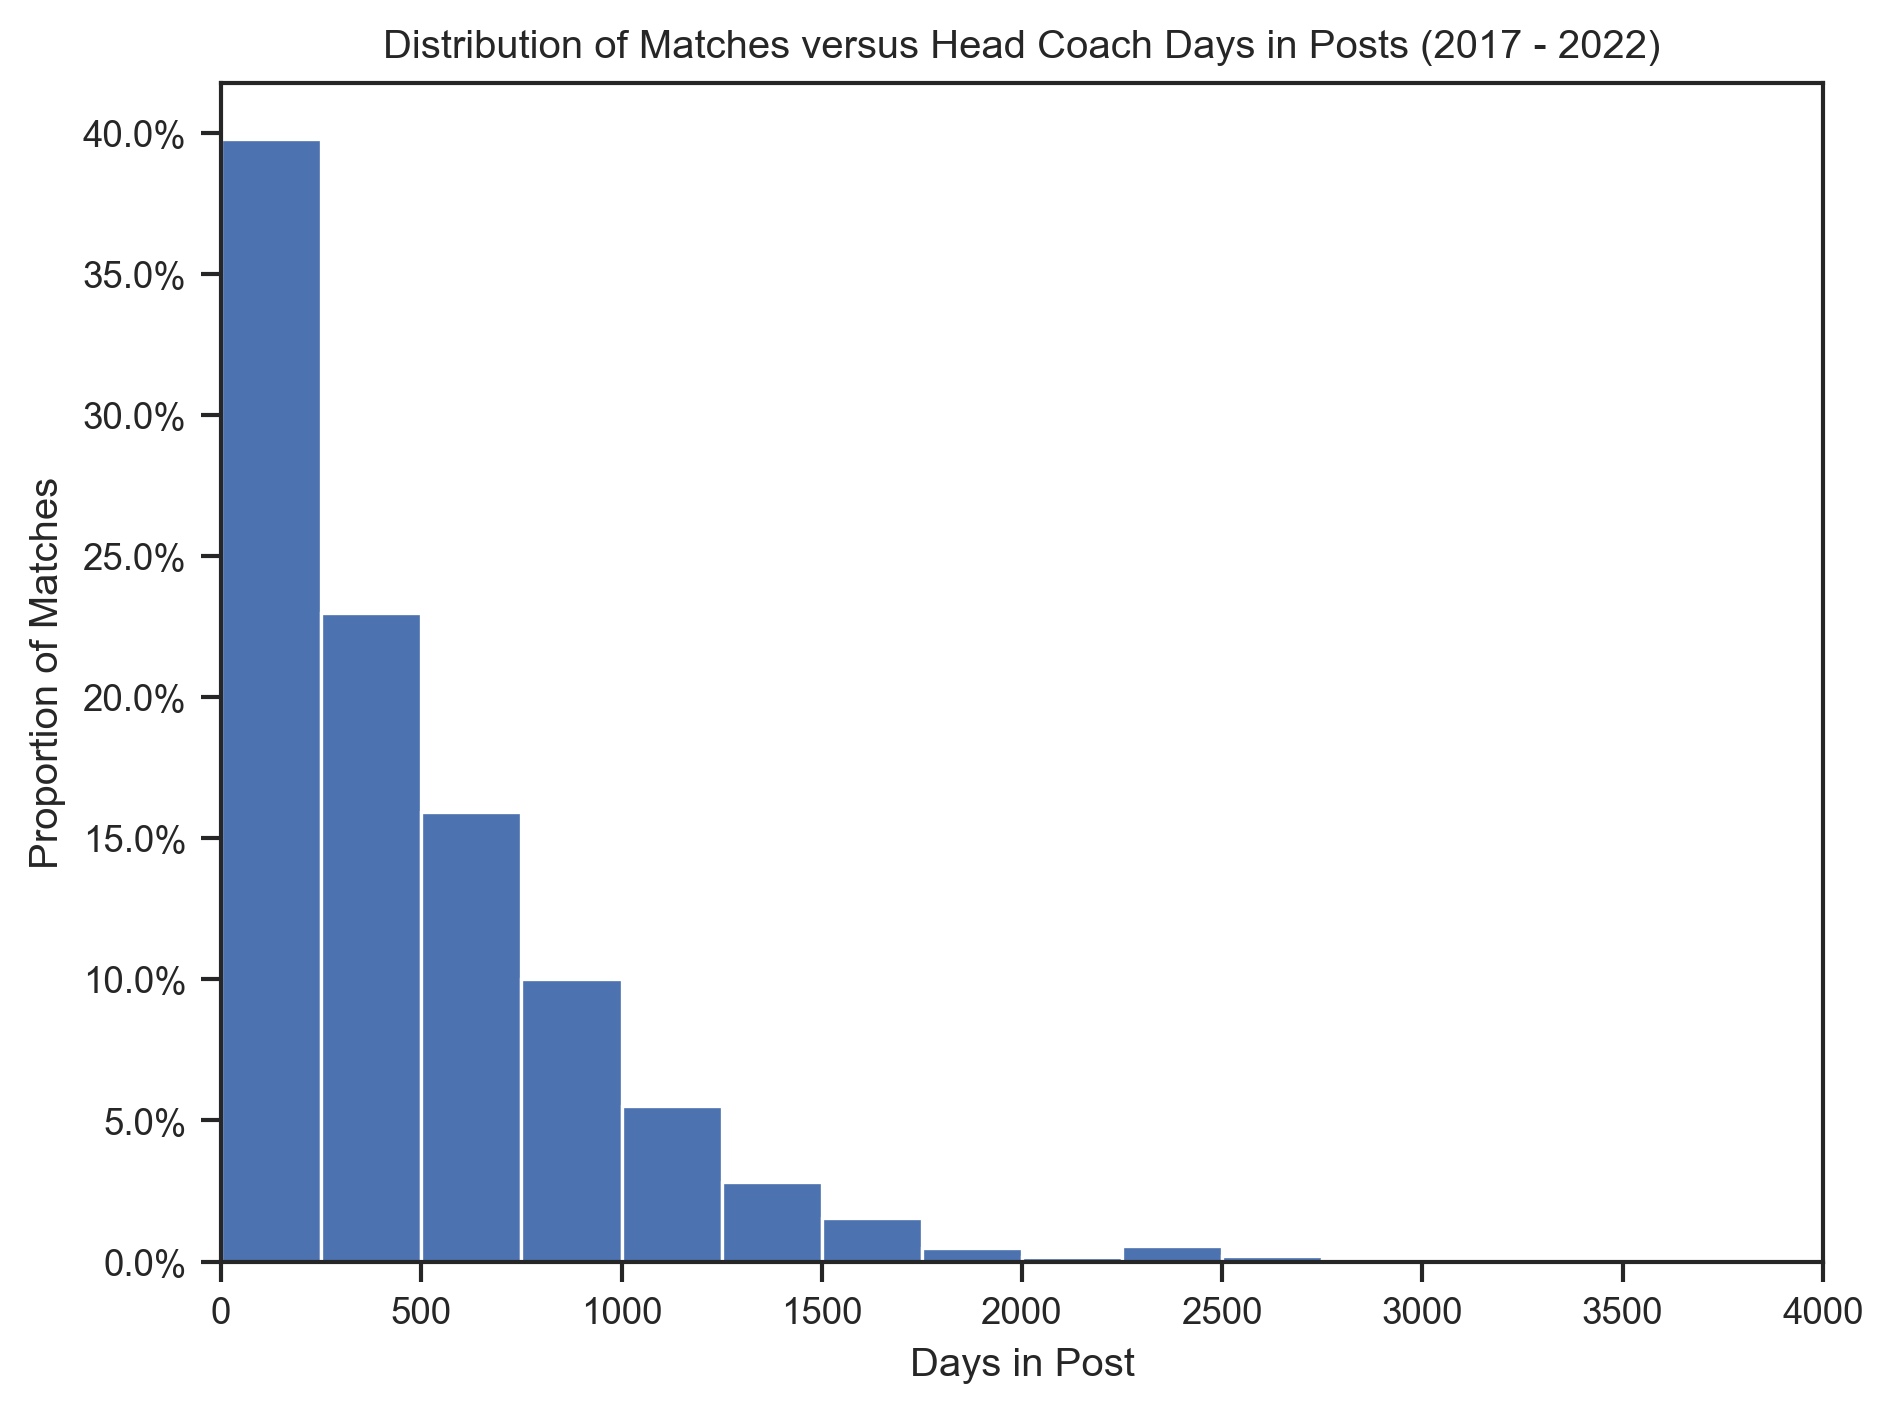

In [23]:
# | label: match_distribution_over_coach_tenure
# Create a histogram of 'match_count' over 'days_in_post'
plt.figure()
sns.histplot(
    data=match_results,
    x="DaysInPost",
    bins=16,
    stat="proportion",
    binrange=(0, 4000),
    alpha=1,
)
plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
plt.xlim(0, 4000)
plt.xlabel("Days in Post")
plt.ylabel("Proportion of Matches")
plt.title("Distribution of Matches versus Head Coach Days in Posts (2017 - 2022)")
plt.show()

In [24]:
def plot_match_outcome_over_coach_tenure(data, y_value, y_label, color):
    # Create a jointplot
    g = sns.jointplot(
        data=data,
        x="DaysInPost",
        y=y_value,
        kind="reg",
        scatter_kws={"alpha": 0.5, "color": color},
        line_kws={"color": color},
        ratio=3,
        marginal_ticks=False,
    )
    g.figure.set_figwidth(6)
    g.figure.set_figheight(2)
    g.figure.suptitle(f"Match outcome over Head Coach Days in Post", x=0.4, y=1.1)
    g.set_axis_labels("Head Coach Days in Post", "Match Outcome")

    # Legend
    r, p = pearsonr(data["DaysInPost"], data[y_value])
    legend = g.ax_joint.legend(
        [f"r = {r:.2f}, p = {p:.2f}"], loc="upper left", bbox_to_anchor=(1, 1.6)
    )
    legend.set_title("Pearson correlation")

    # Set y-axis tick
    g.ax_joint.set_yticks([0, 1])
    g.ax_joint.set_yticklabels(["not " + y_label, y_label])

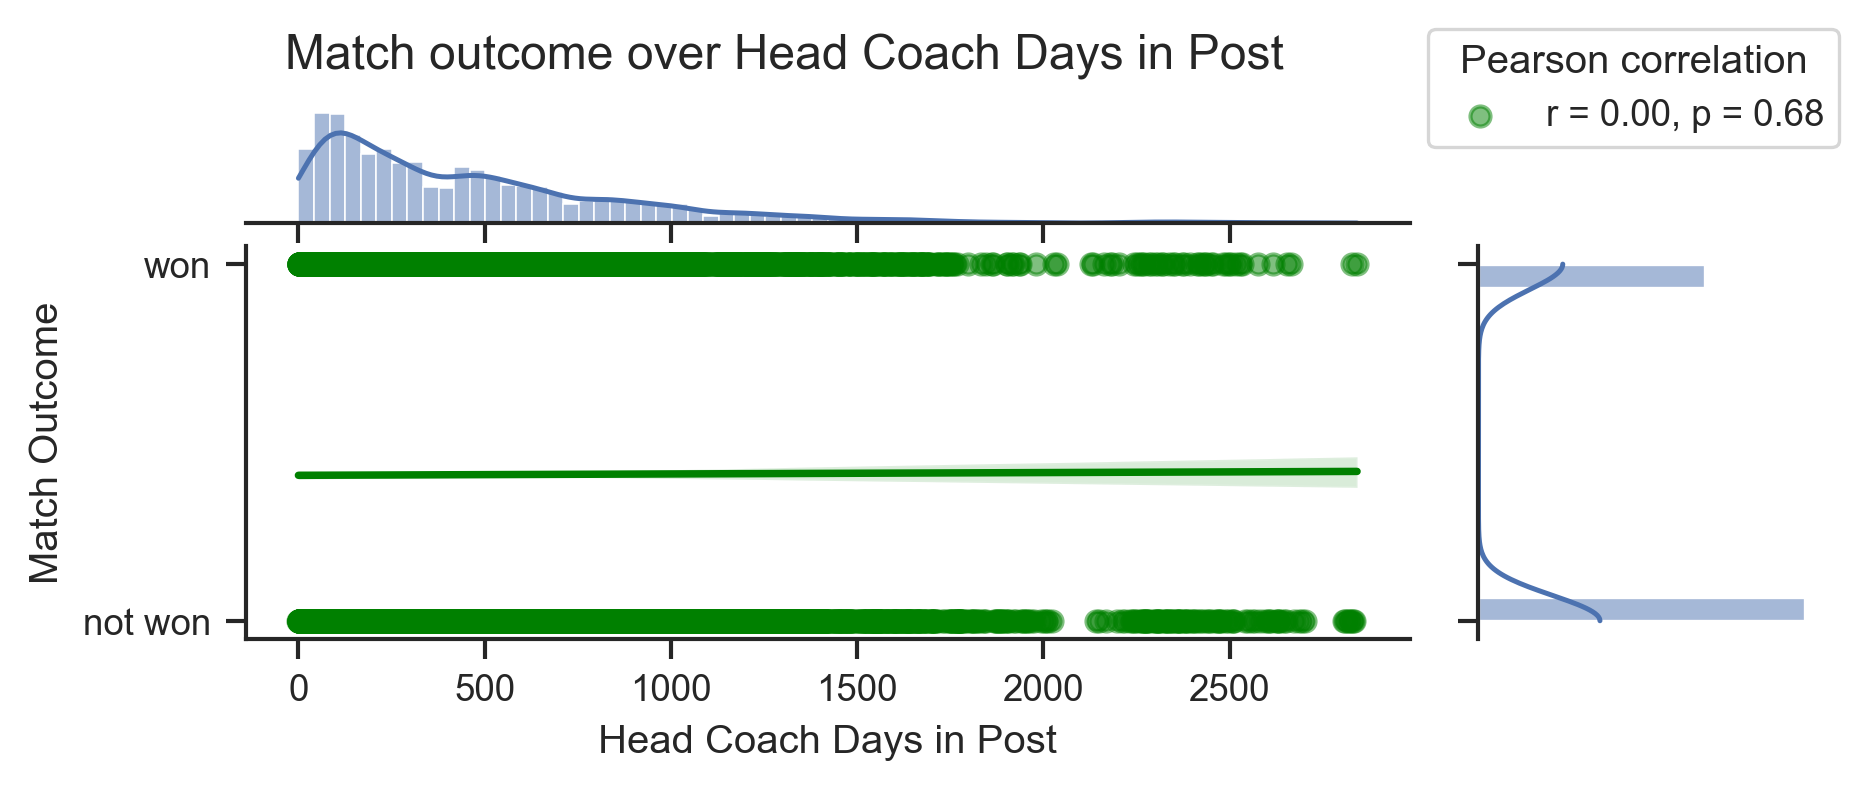

In [25]:
# | label: win_over_coach_tenure
plot_match_outcome_over_coach_tenure(match_results, "Win", "won", "green")

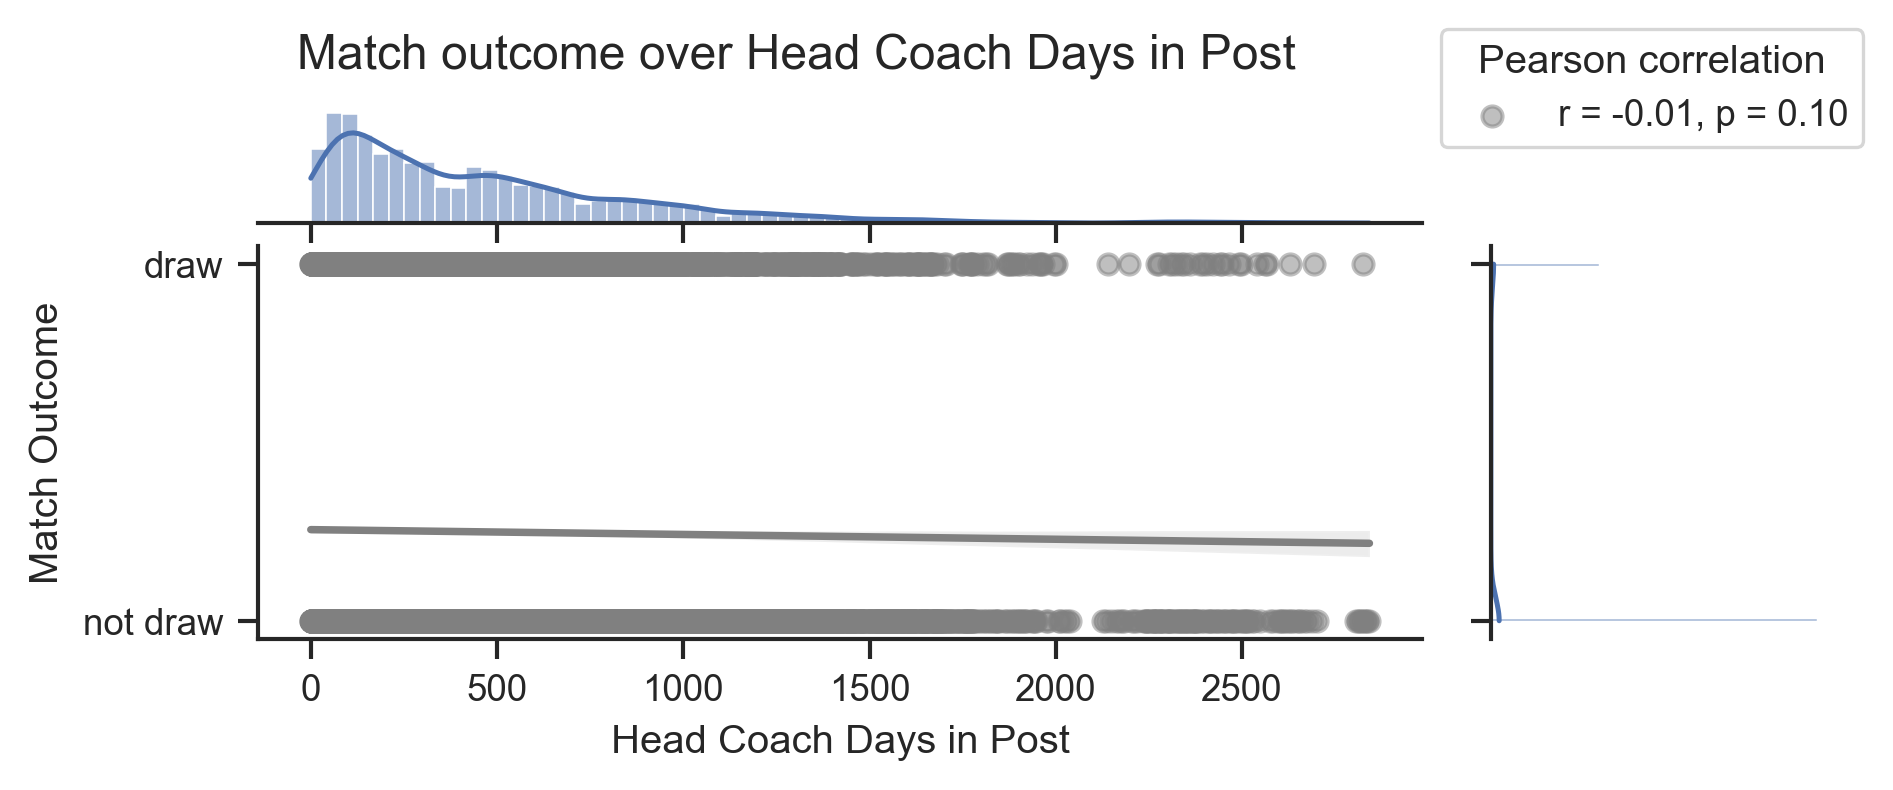

In [26]:
# | label: draw_over_coach_tenure
plot_match_outcome_over_coach_tenure(match_results, "Draw", "draw", "gray")

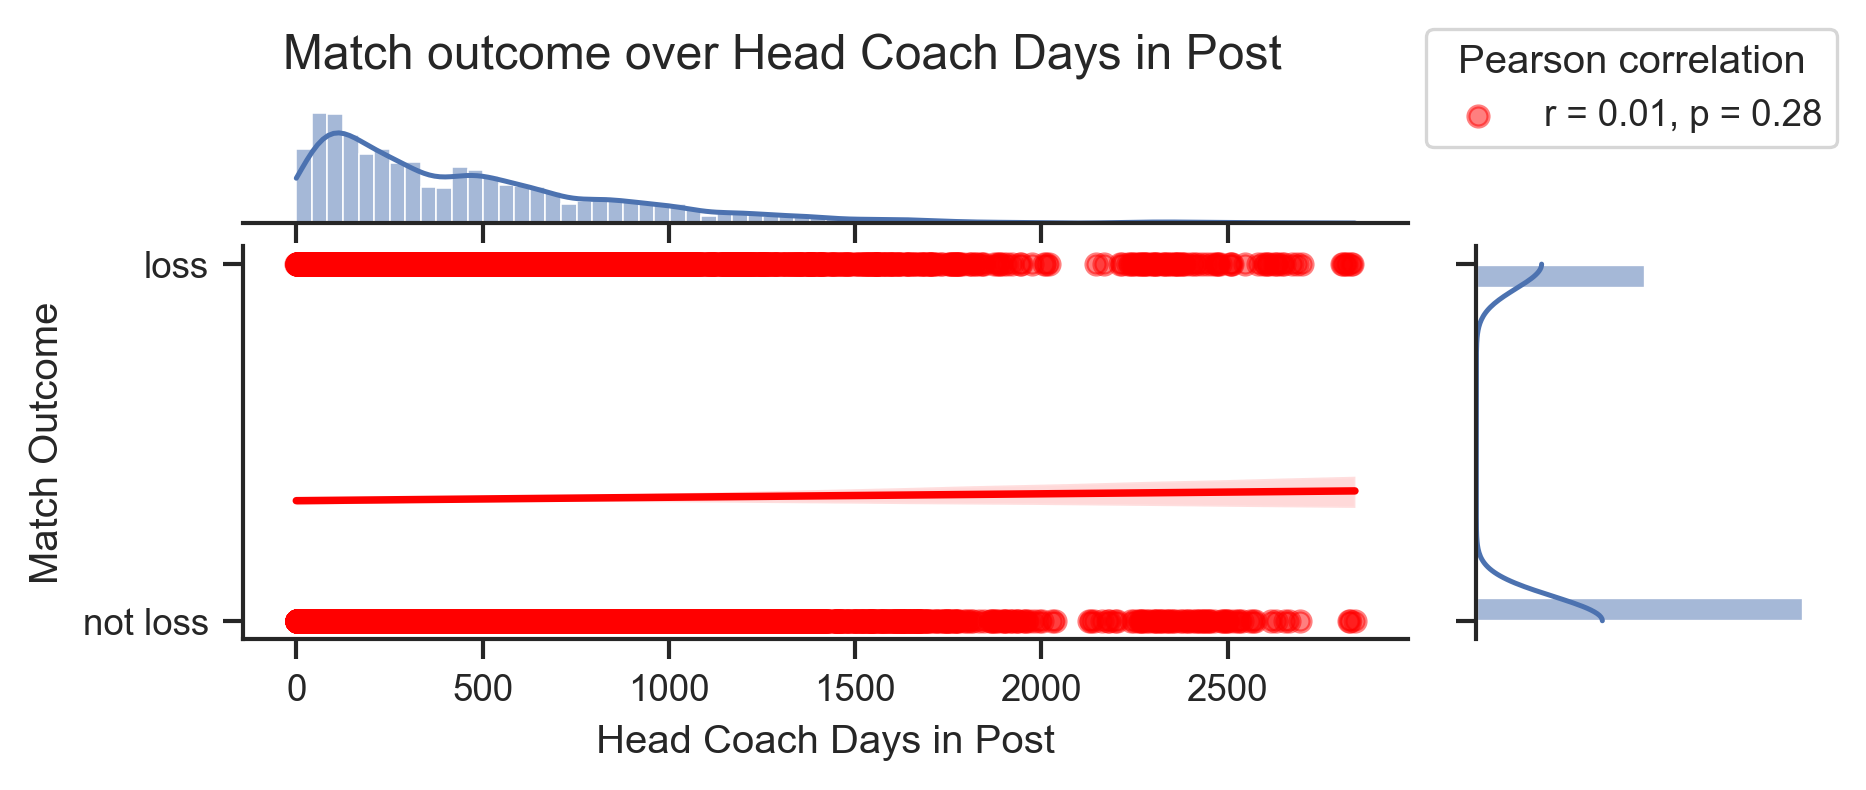

In [27]:
# | label: loss_over_coach_tenure
plot_match_outcome_over_coach_tenure(match_results, "Loss", "loss", "red")

In [28]:
match_results_bis = match_results[match_results["DaysInPost"] < 1500]
match_results_bis = match_results_bis.groupby("DaysInPost").agg(
    {"Win": "mean", "Draw": "mean", "Loss": "mean", "Result": "count"}
)
match_results_bis.columns = ["WinRate", "DrawRate", "LossRate", "MatchCount"]
# Add missing days between the first and last day
match_results_bis = match_results_bis.reindex(
    range(int(min(match_results_bis.index)), int(max(match_results_bis.index) + 1)),
    fill_value=0,
)

In [29]:
def weighted_rolling_mean(data, weights, window_size=50):
    def weighted_mean(x):
        return np.average(data.loc[x.index], weights=weights.loc[x.index])

    return data.rolling(window_size, min_periods=1).apply(weighted_mean, raw=False)


window_size = 100

match_results_bis["WinRateRA"] = weighted_rolling_mean(
    match_results_bis["WinRate"], match_results_bis["MatchCount"], window_size
)
match_results_bis["DrawRateRA"] = weighted_rolling_mean(
    match_results_bis["DrawRate"], match_results_bis["MatchCount"], window_size
)
match_results_bis["LossRateRA"] = weighted_rolling_mean(
    match_results_bis["LossRate"], match_results_bis["MatchCount"], window_size
)

# Ensures it sums to 1
(
    match_results_bis["WinRateRA"]
    + match_results_bis["DrawRateRA"]
    + match_results_bis["LossRateRA"]
).value_counts()

1.0    1465
1.0      33
Name: count, dtype: int64

In [30]:
stats = match_results[match_results["DaysInPost"] < 1500]
n_match = stats["Result"].count()
n_win = stats[stats["Result"] == "win"]["Result"].count()
n_draw = stats[stats["Result"] == "draw"]["Result"].count()
n_loss = stats[stats["Result"] == "loss"]["Result"].count()

Parmi l'ensemble des matchs où l'on possède des informations sur l'entraîneur sportif et où l'entraîneur sportif avait moins de 1500 jours d'ancienneté lors du match :
- le pourcentage de match gagné est de {eval}`f'{n_win/n_match*100:.2f}'` %.
- le pourcentage de match nul est de {eval}`f'{n_draw/n_match*100:.2f}'` %. 
- le pourcentage de match perdu est de {eval}`f'{n_loss/n_match*100:.2f}'` %.

Text(750, 0.13, 'Loss')

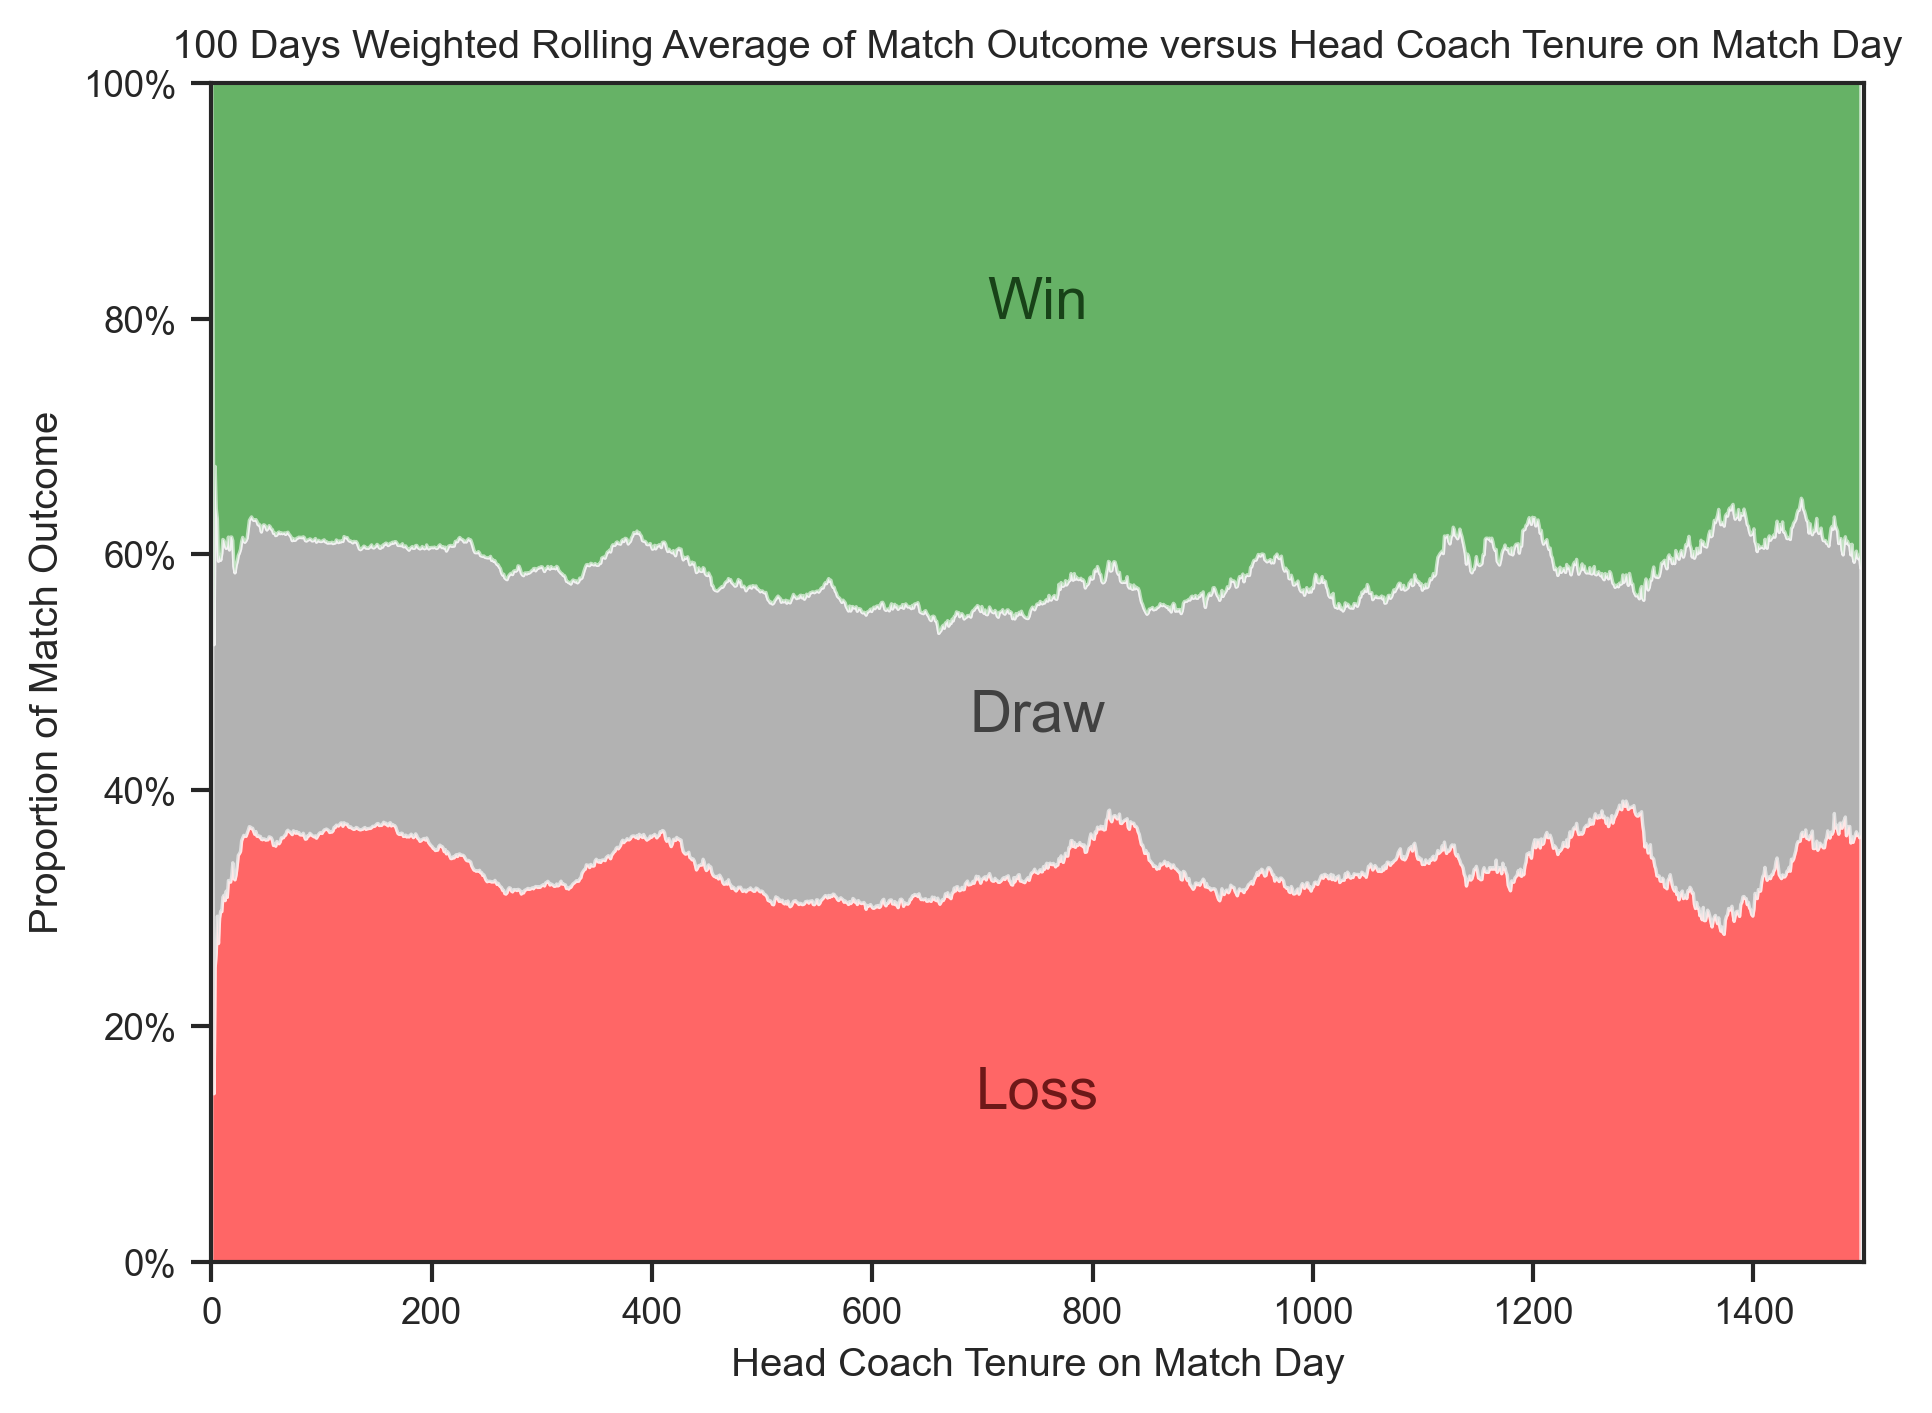

In [31]:
# | label: match_outcome_over_coach_tenure
plt.figure()
plt.stackplot(
    match_results_bis.index,
    match_results_bis["LossRateRA"],
    match_results_bis["DrawRateRA"],
    match_results_bis["WinRateRA"],
    colors=["red", "gray", "green"],
    alpha=0.60,
)
plt.xlabel("Head Coach Tenure on Match Day")
plt.ylabel("Proportion of Match Outcome")
plt.title(
    f"{window_size} Days Weighted Rolling Average of Match Outcome versus Head Coach Tenure on Match Day"
)
plt.gca().spines["left"].set_position(("data", 0))
plt.gca().spines["bottom"].set_position(("data", 0))
plt.gca().spines["top"].set_position(("data", 1))
plt.gca().spines["right"].set_position(("data", 1500))
plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
plt.xlim(0, 1500)
plt.ylim(0, 1)

colors = ["green", "gray", "red"]
light_colors = [sns.dark_palette(color, as_cmap=True)(0.3) for color in colors]
plt.text(750, 0.8, "Win", color=light_colors[0], ha="center", fontsize=14)
plt.text(750, 0.45, "Draw", color=light_colors[1], ha="center", fontsize=14)
plt.text(750, 0.13, "Loss", color=light_colors[2], ha="center", fontsize=14)